In [26]:
import logging, sys
logging.disable(sys.maxsize)
import pymongo
import pandas as pd
import statistics_utility as su
from web3 import Web3
import matplotlib
matplotlib.use('nbagg')
from evaluation.wallet_constant import BURNING_ADDRESSES
from evaluation.wallet_constant import LIQUIDITY_LOCKERS
from evaluation.evaluator import Evaluator
import evaluation.evaluation_config

from matplotlib import pyplot as plt
import numpy as np


plt.rcParams['figure.dpi'] = 400

db_client = pymongo.MongoClient("mongodb://localhost:27017/")
scam_db = db_client["eth-scam-checker"]

#statistics_db = db_client['statistics']
#statistics_rescan_db = db_client['statistics-rescan']
# statistics_db = db_client['statistics-big-legit-dataset']
# statistics_rescan_db = db_client['statistics-big-legit-dataset-rescan']
# statistics_db = db_client['statistics-big-dataset']
# statistics_rescan_db = db_client['statistics-big-dataset-rescan']


# big_dataset_db = db_client['statistics-big-dataset']
# big_dataset_rescan_db = db_client['statistics-big-dataset-rescan']
big_dataset_50_50_db = db_client['big-dataset-50-50']
big_dataset_50_50_rescan_db = scam_db['dataset_collection']

# statistics_db = db_client['big-dataset-50-50']
# statistics_rescan_db = db_client['big-dataset-50-50-rescan']

# testset_db = db_client['testset-db']
# testset_rescan_db = db_client['testset-rescan-db']


# statistics_db = db_client['testset-db']
# statistics_rescan_db = db_client['testset-rescan-db']

logger = logging.getLogger(__name__)


# dataset_file = "./data/big_dataset_annotated_with_legit.csv"
# data = pd.read_csv(dataset_file)

#dataset_file = "./data/first_dataset.CSV"
#data = pd.read_csv(dataset_file)

# dataset_file = "./data/big_dataset_annotated.csv"
# data = pd.read_csv(dataset_file)

# dataset_file = "./data/big_dataset_annotated.csv"
# data = pd.read_csv(dataset_file)

# dataset_file = "./data/random_tokens_annotated.csv"
# data = pd.read_csv(dataset_file)

dataset_file = "./dataset/training_dataset.csv"
# dataset_file = "./data/big_dataset_current.csv"
data = pd.read_csv(dataset_file)


dataset_testset_file = "./dataset/TrainingDatasetNew.csv"
data_testset = pd.read_csv(dataset_testset_file)

# dataset_file = "./data/test_dataset.CSV"
# data = pd.read_csv(dataset_file)

    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Liquidity Amount Setup

In [17]:
# eth amount plot
liquidity_values = []
annotations = []
numbers = []
no_eth_pair_scam = 0
no_eth_pair_benign = 0

low_liquidity_scam_count = 0
low_liquidity_benign_count = 0

liquidity_scam = []
liquidity_benign = []

r = np.arange(1)
width = 0.25

# for index, entry in data_testset.iterrows():
for index, entry in data.iterrows():
#     token = testset_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    token = scam_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    if token is None:
        token = big_dataset_50_50_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
        if token is None:
            print(entry['address'])

    evaluator = Evaluator(token, evaluation.evaluation_config.DEFAULT_CONFIG)            
    eth_liquidity = evaluator.get_eth_liquidity()

    if eth_liquidity is None:
        if entry['scam'] == 1:
            no_eth_pair_scam += 1
            print(token['address'])
            print("INVALID")
        else:
            no_eth_pair_benign += 1
        continue

    elif eth_liquidity > 400:
        liquidity_values.append(405)
        numbers.append(index)
        annotations.append(entry['scam'])
    else:
        liquidity_values.append(eth_liquidity)
        numbers.append(index)
        annotations.append(entry['scam'])
    
    if eth_liquidity is not None and eth_liquidity > 40:
        if entry['scam'] == 1:
            low_liquidity_scam_count += 1
        else:
            low_liquidity_benign_count += 1
            
    if eth_liquidity is not None:
        if entry['scam'] == 1:
            liquidity_scam.append(eth_liquidity)
        else:
            liquidity_benign.append(eth_liquidity)
        

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

df_liquidity_values = pd.DataFrame({"x": np.arange(len(liquidity_values)), "y":liquidity_values, "scam":annotations})

plot_colors = []

for i in annotations:
    plot_colors.append(colors[i])
      
        
print()
print(df_liquidity_values)


0x5516AC1aaCa7BB2fD5b7bDDE1549Ef1Ea242953d
INVALID

         x             y  scam
0        0  8.374059e+00     0
1        1  3.166090e+00     0
2        2  6.372451e+00     0
3        3  1.000000e+00     0
4        4  3.505985e+01     0
...    ...           ...   ...
1994  1994  1.450000e-16     1
1995  1995  1.010000e+00     1
1996  1996  2.344145e+00     1
1997  1997  6.926435e+00     1
1998  1998  3.309016e+00     1

[1999 rows x 3 columns]


In [18]:
scams = 0
benign = 0
for index, row in df_liquidity_values.iterrows():
    if row['y'] <= 0.15: # and row['y'] > 2.99:
        if row['scam'] == 1:
            scams += 1
        else:
            benign += 1
            
print(scams)
print(benign)
print(100 / (scams + benign) * scams)

import seaborn as sns
%matplotlib notebook

bins = np.arange(0,40,0.5)
# bins = 100
# ax = plt.hist(liquidity_benign, cumulative=True, density=True, bins=bins)
# ax = sns.distplot(liquidity_scam, bins=bins, label='Scam Contract', )
# ax.set(xlim=(0, 40))
# ax.set(ylim=(0, 1))

# axs3.bar(r, [no_eth_pair_scam], color='r', width=width, label='scams')
# axs3.bar(r+width, [no_eth_pair_benign], color='g', width=width, label='benign')
# ax.grid(visible = True, color ='grey',
#         linestyle ='-.', linewidth = 0.5,
#         alpha = 0.2)
# plt.xlim([0,100])
# plt.ylabel('Number of Contracts', fontsize = 15)
# plt.xlabel('Amount of WETH', fontsize = 15)
# plt.legend()

print(no_eth_pair_scam + no_eth_pair_benign)
# plt.savefig('eth_amount_plot_2.pdf')  
# plt.show()



158
124
56.02836879432624
1


### Liquidity Amount Plot
plots different views based on the previous setup cell

In [27]:
%matplotlib notebook
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('legend', fontsize=18)    # legend fontsize

fig, ax = plt.subplots(figsize =(9, 6))
# axs1.hist(liquidity_values, bins=60)
bins = np.arange(0,1.1,0.02)
# bins = 100
ax.hist((liquidity_benign, liquidity_scam), bins=bins, label=('Benign Contract','Scam Contract'))

# axs3.bar(r, [no_eth_pair_scam], color='r', width=width, label='scams')
# axs3.bar(r+width, [no_eth_pair_benign], color='g', width=width, label='benign')

# ax.grid(visible = True, color ='grey',
#         linestyle ='-.', linewidth = 0.5,
#         alpha = 0.2)

# plt.xlim([0,100])
plt.ylabel('Number of Contracts', fontsize = 18)

plt.xlabel('Amount of WETH', fontsize = 18)
plt.legend()

print(no_eth_pair_scam + no_eth_pair_benign)
plt.savefig('eth_amount_plot_0_1.1.pdf')  
plt.show()

print(1.0 / (low_liquidity_scam_count + low_liquidity_benign_count) * low_liquidity_scam_count)

<IPython.core.display.Javascript object>

1
0.40350877192982454


In [28]:
%matplotlib notebook
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('legend', fontsize=18)    # legend fontsize

fig, ax = plt.subplots(figsize =(9, 6))

# axs1.hist(liquidity_values, bins=60)
bins = np.arange(0,10,0.1)
# bins = 100
ax.hist((liquidity_benign, liquidity_scam), bins=bins, label=('Benign Contract','Scam Contract'))

# axs3.bar(r, [no_eth_pair_scam], color='r', width=width, label='scams')
# axs3.bar(r+width, [no_eth_pair_benign], color='g', width=width, label='benign')

# ax.grid(visible = True, color ='grey',
#         linestyle ='-.', linewidth = 0.5,
#         alpha = 0.2)

# plt.xlim([0,100])
plt.ylabel('Number of Contracts', fontsize = 18)

plt.xlabel('Amount of WETH', fontsize = 18)
plt.legend()

print(no_eth_pair_scam + no_eth_pair_benign)
plt.savefig('eth_amount_plot_0_10.pdf')  
plt.show()

print(1.0 / (low_liquidity_scam_count + low_liquidity_benign_count) * low_liquidity_scam_count)

<IPython.core.display.Javascript object>

1
0.40350877192982454


<IPython.core.display.Javascript object>


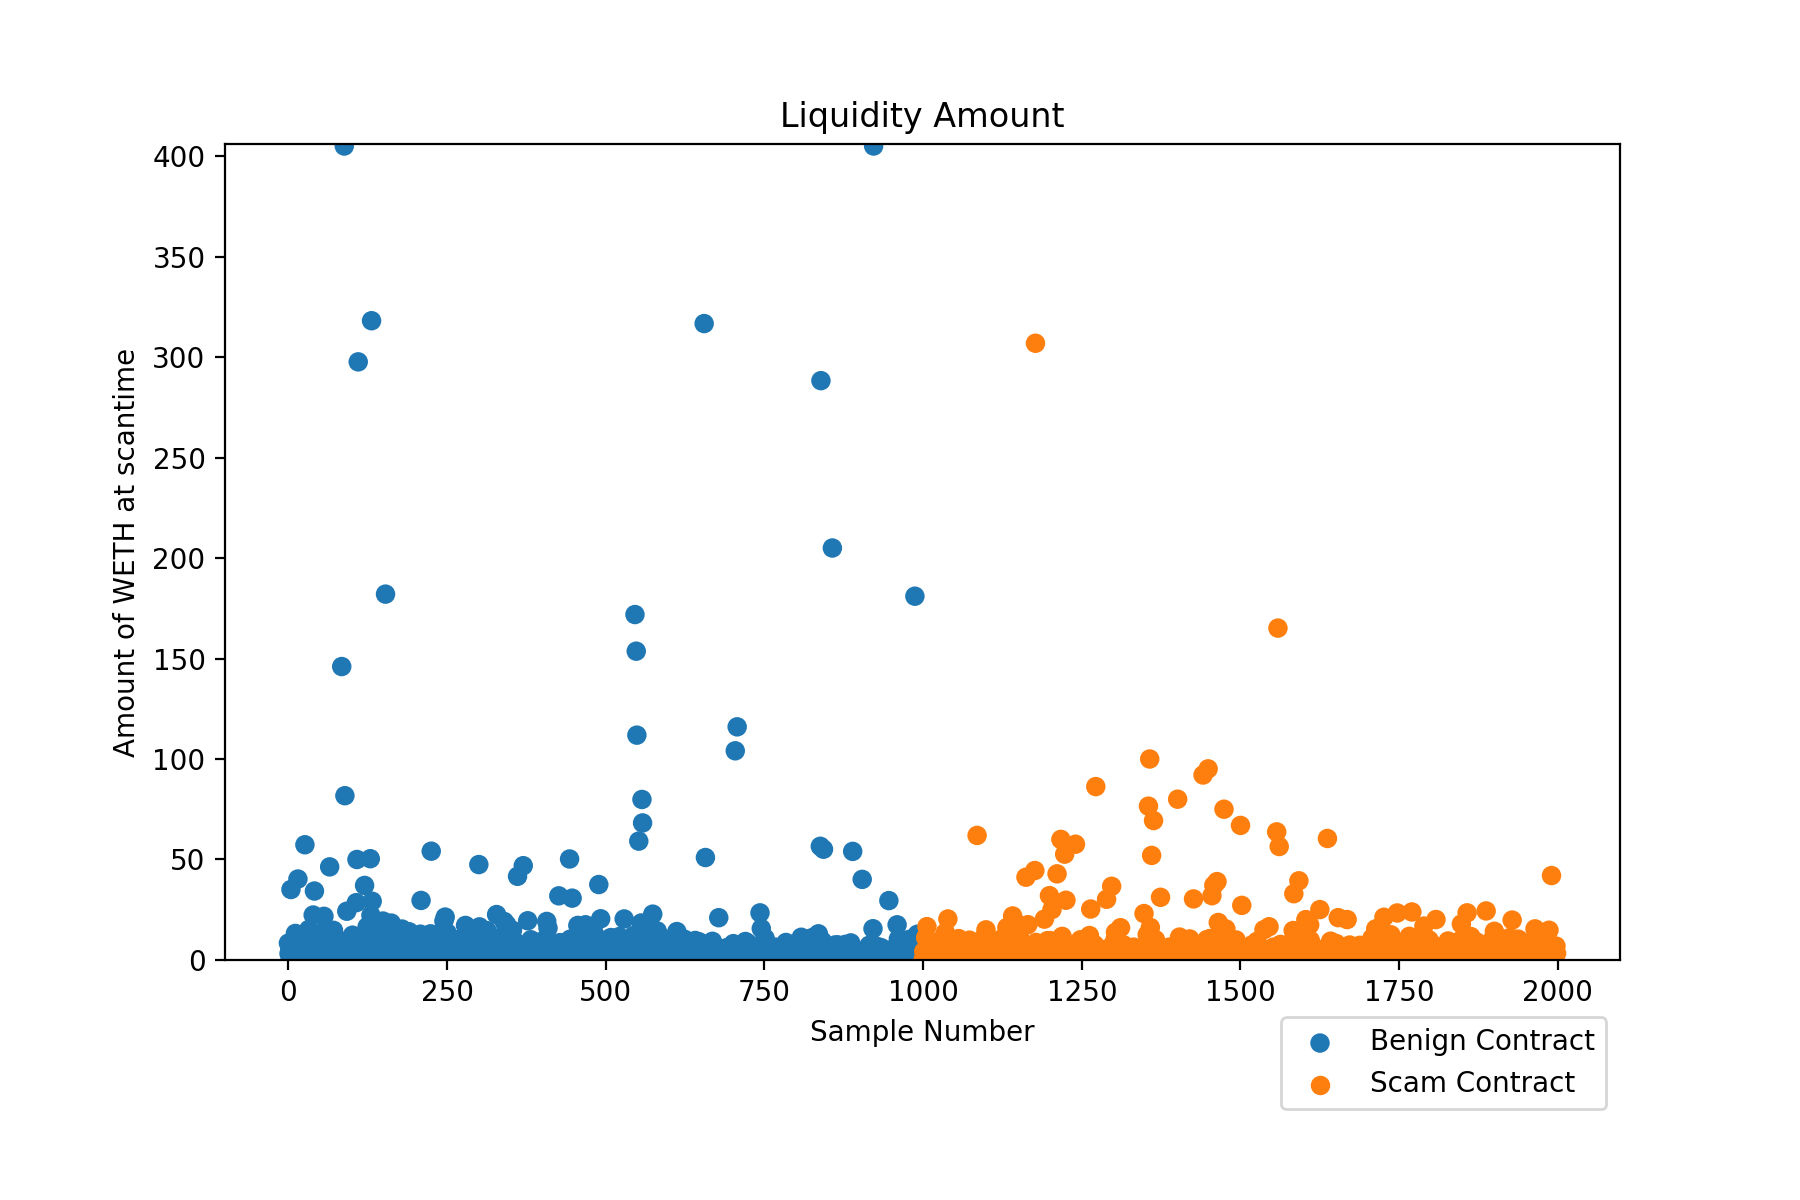

In [100]:
%matplotlib notebook

fig, ax = plt.subplots(figsize =(9, 6))

# ax.semilogy()
ax.scatter(df_liquidity_values['x'], df_liquidity_values['y'] , c=plot_colors, label="Benign Contract") #label=annotations)
ax.scatter(None, None , c=colors[1], label="Scam Contract")
ax.set_ylabel("Amount of WETH at scantime")
ax.set_xlabel("Sample Number")
ax.set_title("Liquidity Amount")
plt.legend(loc=4, bbox_to_anchor=(1,-0.2))
plt.subplots_adjust(bottom=0.2)

plt.ylim([-0.01,406])
plt.show()

<IPython.core.display.Javascript object>


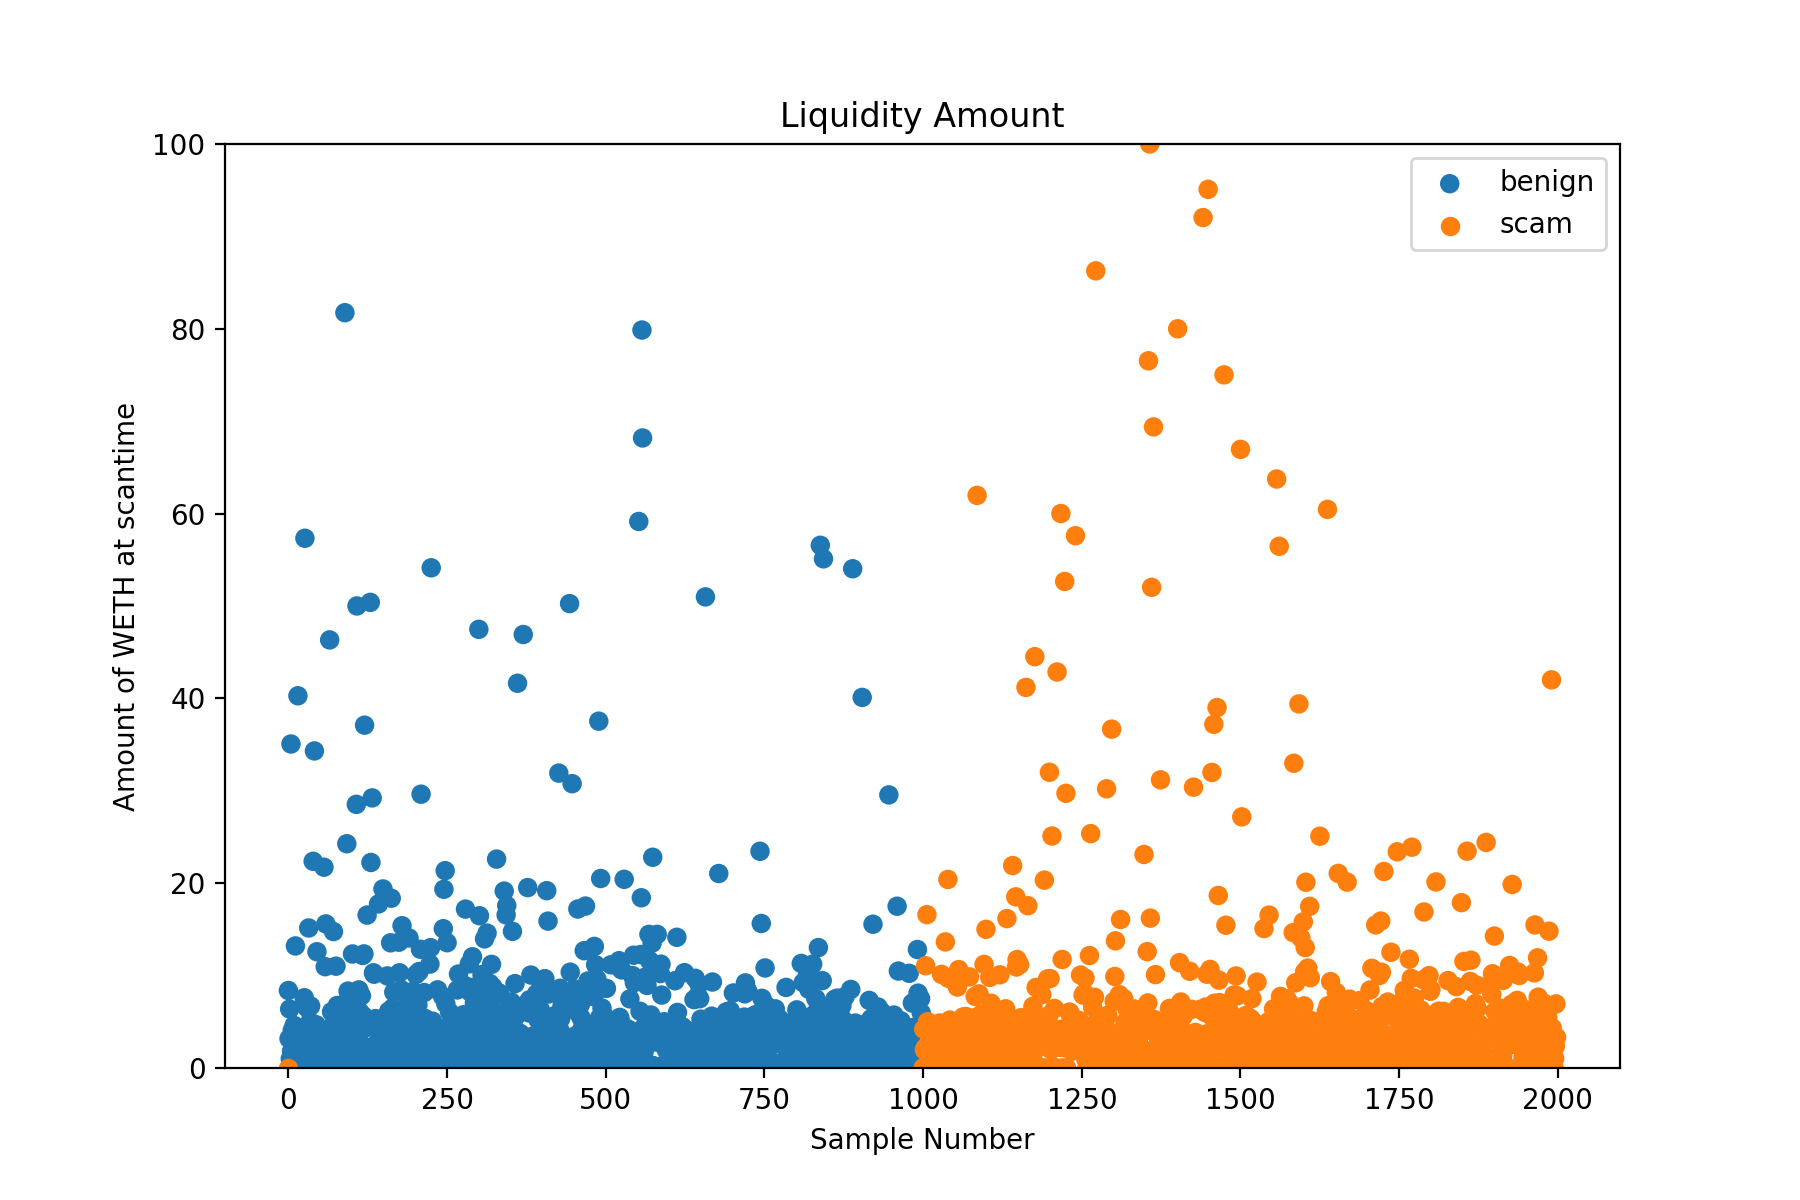

In [101]:
%matplotlib notebook

fig, ax = plt.subplots(figsize =(9, 6))

# ax.semilogy()
ax.scatter(df_liquidity_values['x'], df_liquidity_values['y'] , c=plot_colors, label="benign") #label=annotations)
ax.scatter(0, 0 , c=colors[1], label="scam")

# ax.scatter(np.arange(len(liquidity_values)), liquidity_values , c=annotations) #label=annotations)
ax.set_ylabel("Amount of WETH at scantime")
ax.set_xlabel("Sample Number")
ax.set_title("Liquidity Amount")
ax.legend()
plt.ylim([-0.01,100])
plt.show()

<IPython.core.display.Javascript object>


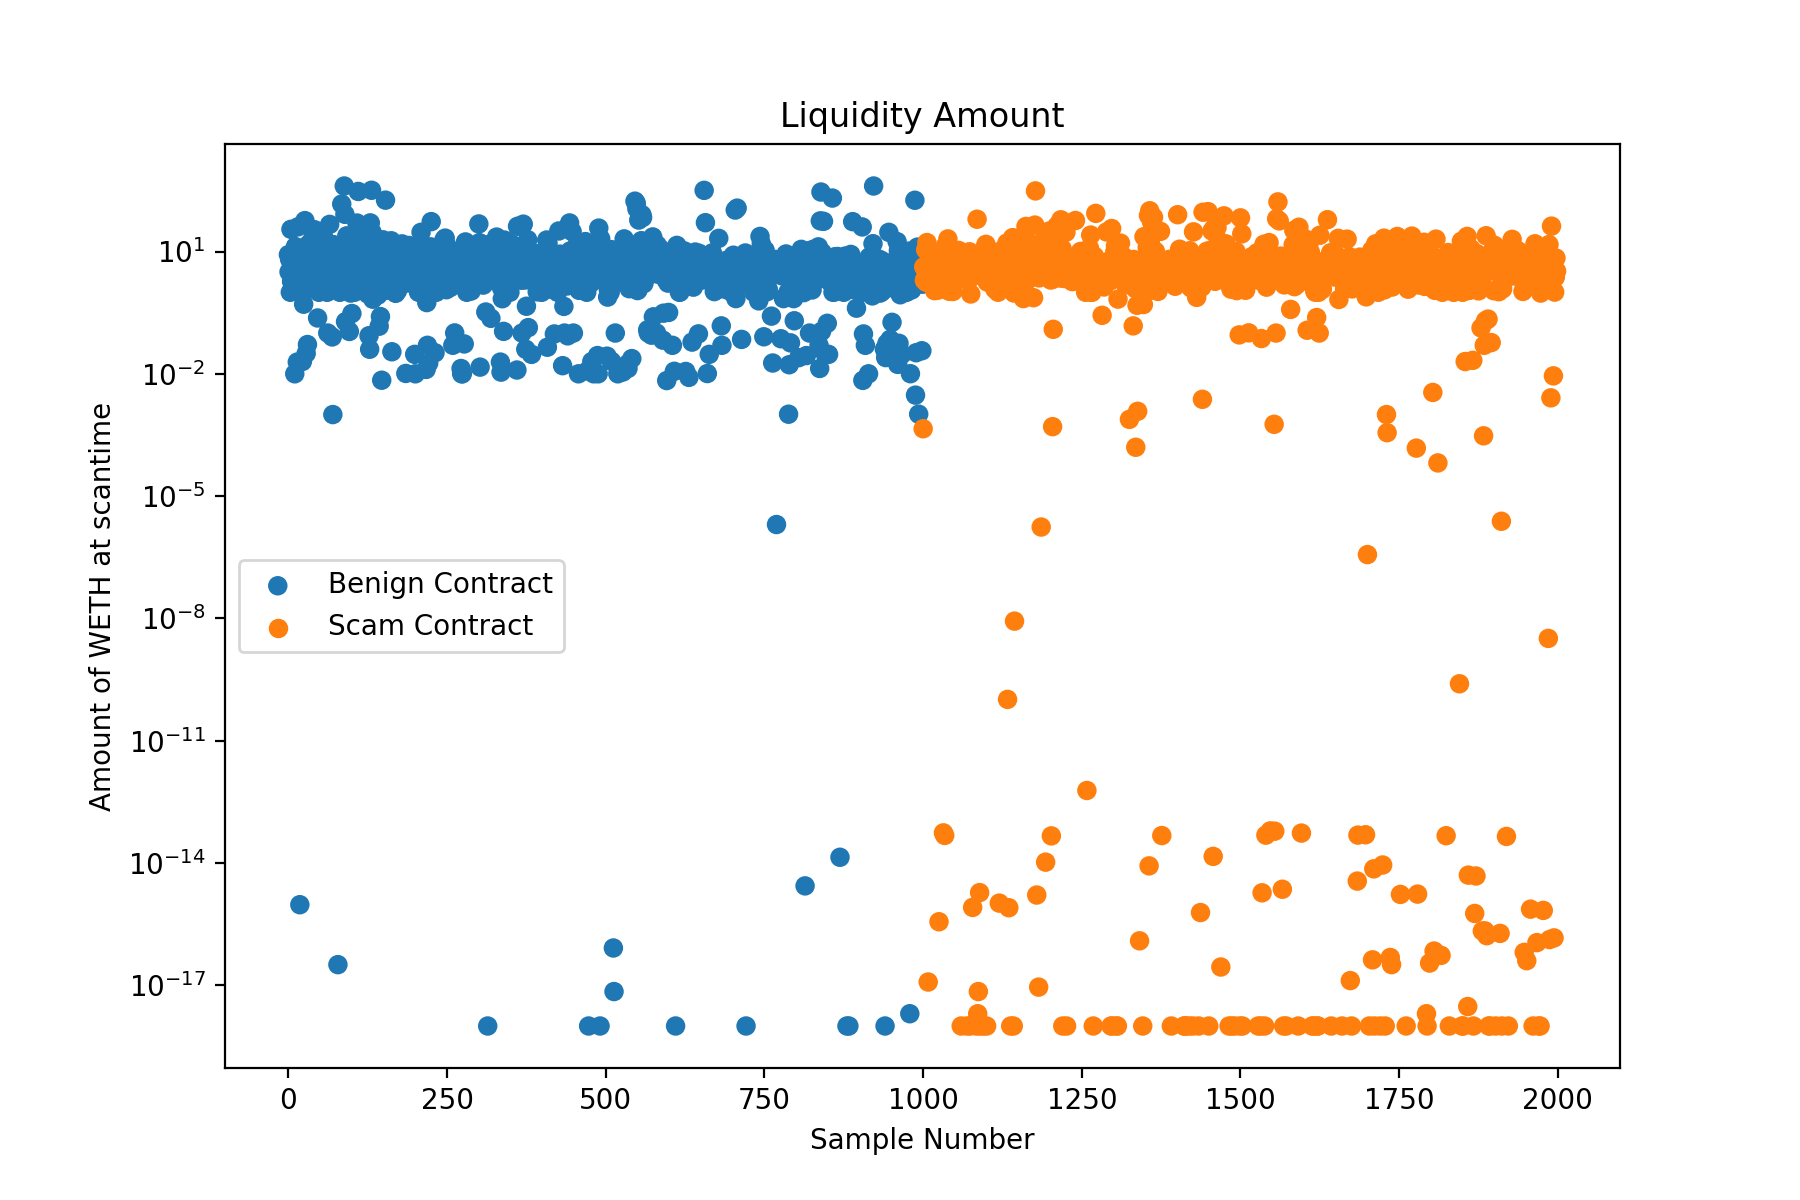

In [118]:
%matplotlib notebook

fig, ax = plt.subplots(figsize =(9, 6))
ax.semilogy()

# for i, dff in df_liquidity_values.groupby("scam"):
#     ax.scatter(dff['x'], dff['y'], c=colors[i])
ax.scatter(df_liquidity_values['x'], df_liquidity_values['y'] , c=plot_colors, label="Benign Contract") #label=annotations)
ax.scatter(0, 0 , c=colors[1], label="Scam Contract")
ax.set_ylabel("Amount of WETH at scantime")
ax.set_xlabel("Sample Number")
ax.set_title("Liquidity Amount")
ax.legend()
# plt.ylim([-80,1250])
plt.show()

<IPython.core.display.Javascript object>


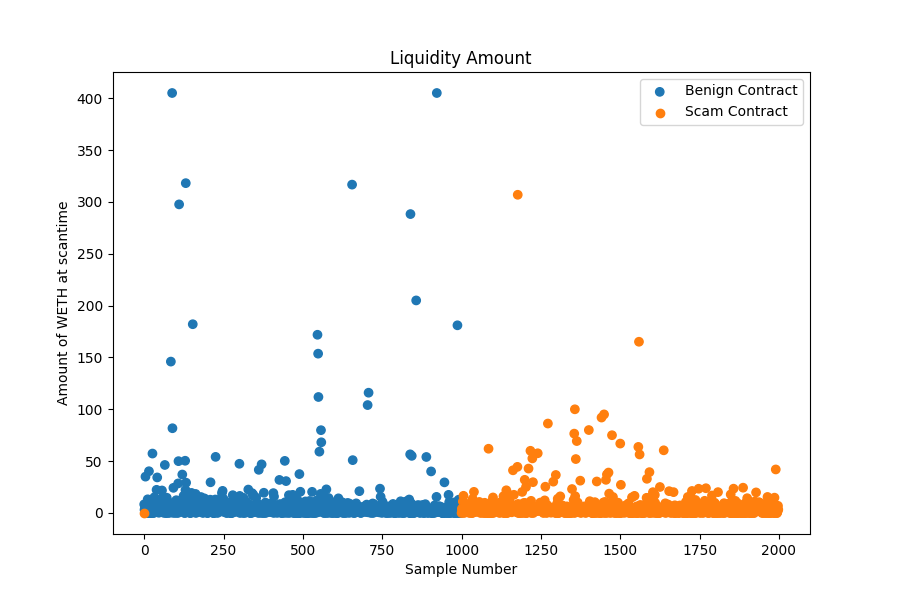

In [51]:
%matplotlib notebook

fig, ax = plt.subplots(figsize =(9, 6))

# ax.semilogy()
ax.scatter(df_liquidity_values['x'], df_liquidity_values['y'] , c=plot_colors, label="Benign Contract") #label=annotations)
ax.scatter(0, 0 , c=colors[1], label="Scam Contract")
ax.set_ylabel("Amount of WETH at scantime")
ax.set_xlabel("Sample Number")
ax.set_title("Liquidity Amount")
ax.legend()
plt.show()

### Liquidity holder shares setup
Collects data and formats it for further processing

In [24]:
liquidity_holder_values = []
annotations = []
numbers = []

liquidity_holders_benign = []
liquidity_holders_scam = []


liquidity_scores_scam = []
liquidity_scores_benign = []

most_burnt_scam_counter = 0
no_most_burnt_scam_counter = 0
most_burnt_benign_counter = 0
no_most_burnt_benign_counter = 0

# for index, entry in data_testset.iterrows():
for index, entry in data.iterrows():
#     token = testset_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    token = scam_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    
    annotations.append(entry['scam'])
    numbers.append(index)
    
    evaluator = Evaluator(token, evaluation.evaluation_config.DEFAULT_CONFIG)            
    
    score = evaluator._evaluate_liquidity_holders()
    
    share = evaluator.get_highest_liquidity_holder_share()

#     if mostly_burnt:
#         if entry['Scam'] == 1:
#             most_burnt_scam_counter += 1
#         else:
#             most_burnt_benign_counter += 1
#     else:
#         if entry['Scam'] == 1:
#             no_most_burnt_scam_counter += 1
#         else:
#             no_most_burnt_benign_counter += 1
    if entry['scam'] == 1:
        liquidity_scores_scam.append(score)
    else:
        liquidity_scores_benign.append(score)

    if share is None:
        liquidity_holder_values.append(-1)
        if entry['scam'] == 1:
            liquidity_holders_scam.append(-1)
        else:
            liquidity_holders_benign.append(-1)
    else:
        liquidity_holder_values.append(share)
        if entry['scam'] == 1:
            liquidity_holders_scam.append(share)
        else:
            liquidity_holders_benign.append(share)

        
# print(liquidity_holder_values)
# print(len(liquidity_holder_values))

# print(annotations)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

df_liquidity_holder_values = pd.DataFrame({"x": np.arange(len(liquidity_holder_values)), "y":liquidity_holder_values, "scam":annotations})

plot_colors = []

for i in annotations:
    plot_colors.append(colors[i])


### Liquidity holder share plots
Needs the previous cell to be run to ensure all data is up to date

<IPython.core.display.Javascript object>


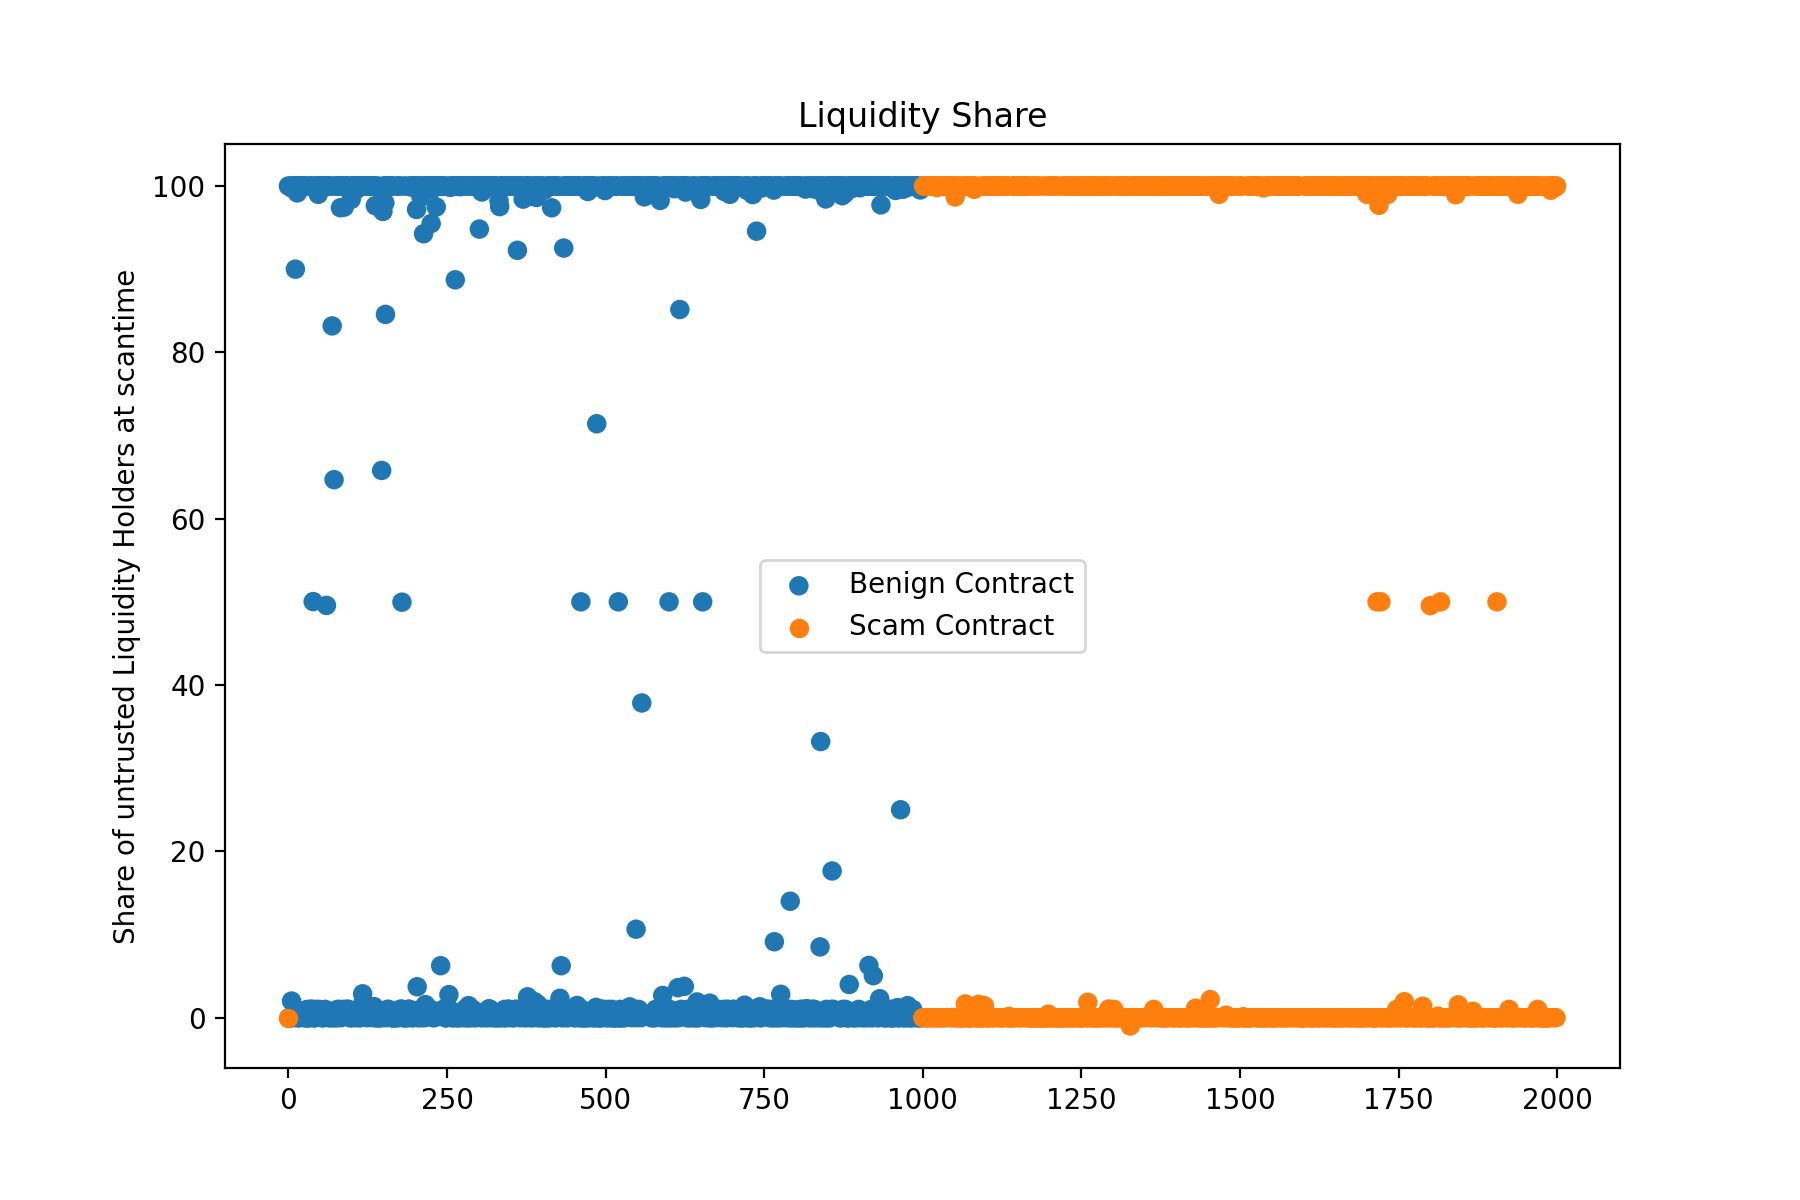

In [166]:


%matplotlib notebook
fig, ax = plt.subplots(figsize =(9, 6))

ax.scatter(df_liquidity_holder_values['x'], df_liquidity_holder_values['y'] , c=plot_colors, label="Benign Contract") #label=annotations)
ax.scatter(0, 0 , c=colors[1], label="Scam Contract")
plt.ylabel("Share of untrusted Liquidity Holders at scantime")
plt.title("Liquidity Share")
plt.legend()
plt.show()

In [29]:
%matplotlib notebook
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('legend', fontsize=18)    # legend fontsize

fig, ax = plt.subplots(figsize =(9, 6))

bins = np.arange(0,5,0.1)
plt.hist((liquidity_holders_benign, liquidity_holders_scam), bins=bins, label=("Benign Contract","Scam Contract"))
plt.ylabel("Amount of Contracts")
plt.xlabel("Highest Liquidity Holder Share [%]")
plt.legend()
plt.title("Liquidity Holder Share")
plt.savefig("histogram_liquidity_pool_0_5.pdf")

<IPython.core.display.Javascript object>

In [30]:
%matplotlib notebook
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('legend', fontsize=18)    # legend fontsize

fig, ax = plt.subplots(figsize =(9, 6))

bins = np.arange(0,105,1)
plt.hist((liquidity_holders_benign, liquidity_holders_scam), bins=bins, label=("Benign Contract","Scam Contract"))
plt.ylabel("Amount of Contracts")
plt.xlabel("Highest Liquidity Holder Share [%]")
plt.legend()
plt.title("Liquidity Holder Share")
plt.savefig("histogram_liquidity_pool_0_100.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


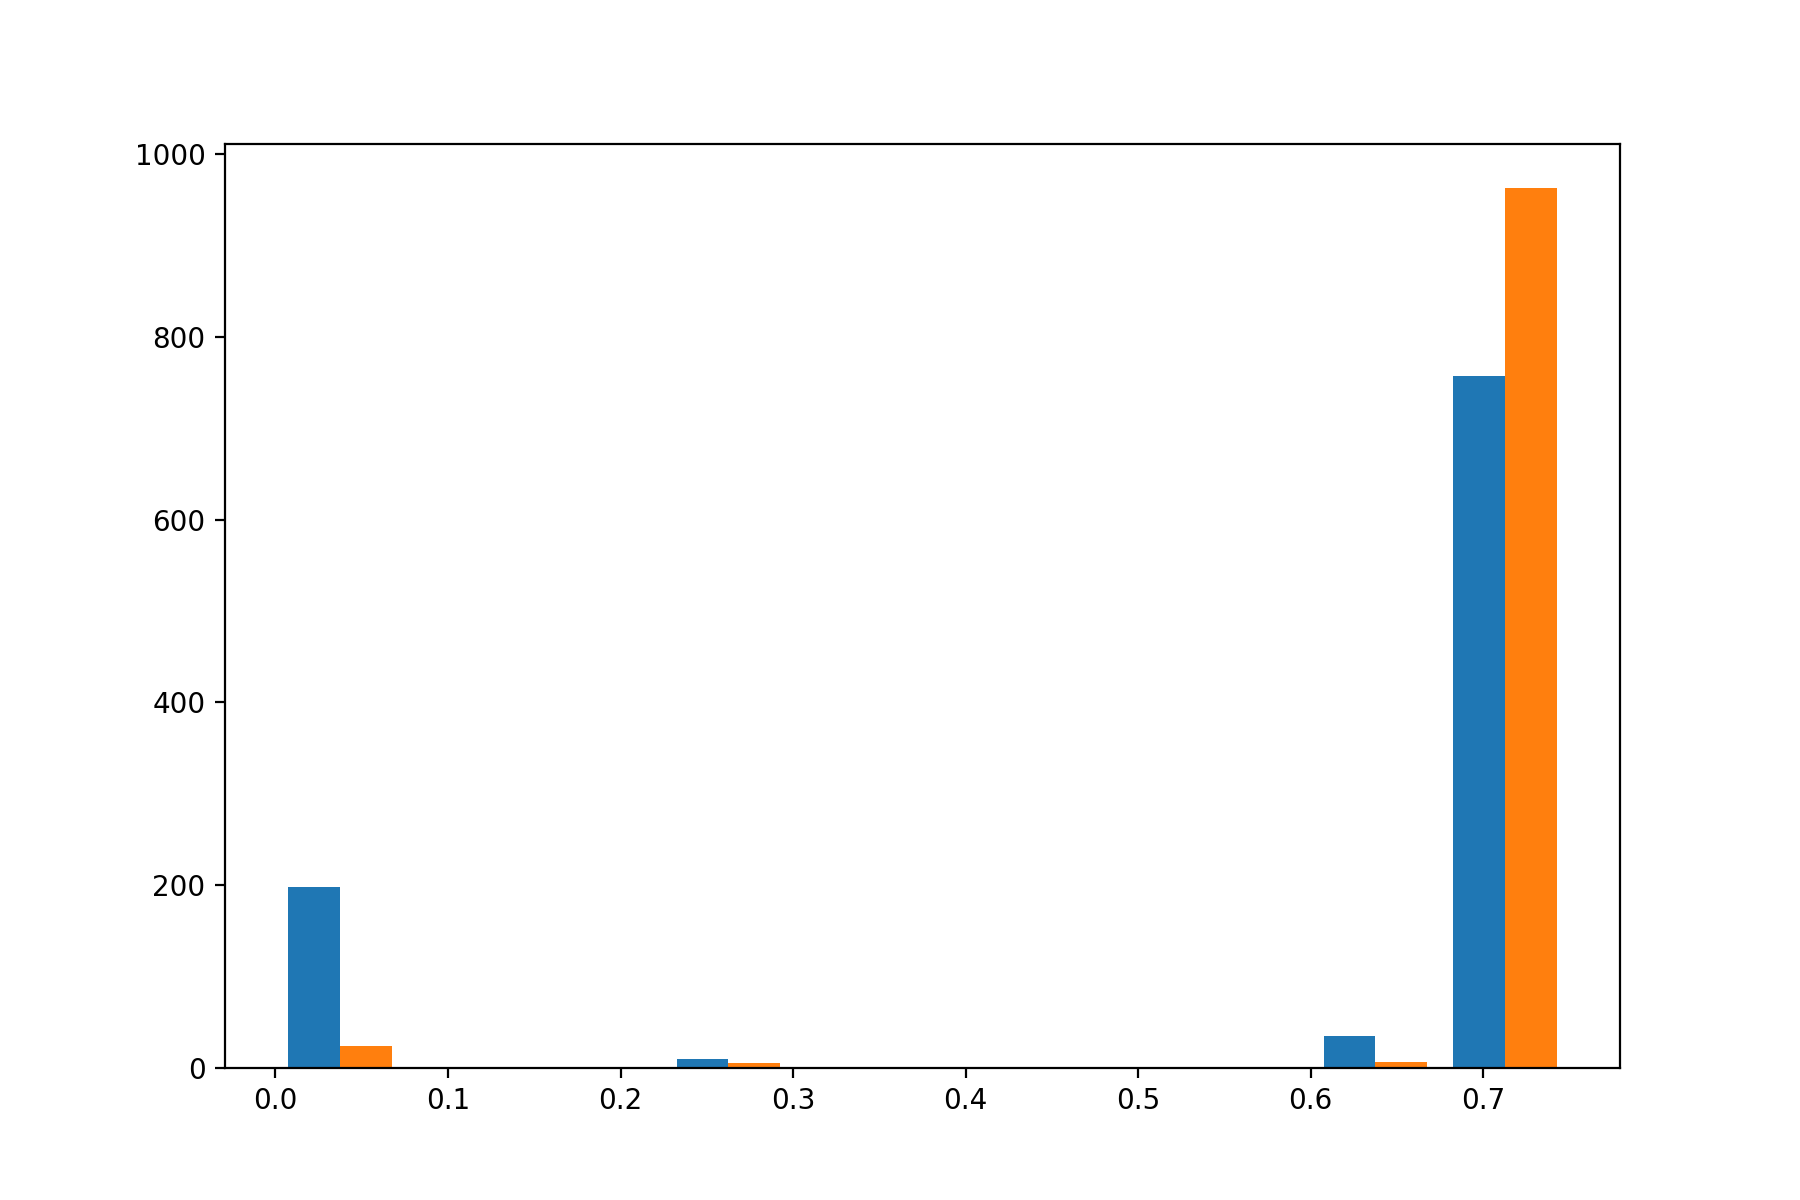

(array([[198.,   0.,   0.,  10.,   0.,   0.,   0.,   0.,  35., 757.],
        [ 24.,   0.,   0.,   5.,   0.,   0.,   1.,   0.,   7., 963.]]),
 array([0.   , 0.075, 0.15 , 0.225, 0.3  , 0.375, 0.45 , 0.525, 0.6  ,
        0.675, 0.75 ]),
 <a list of 2 BarContainer objects>)

In [41]:
%matplotlib notebook
fig, ax = plt.subplots(figsize =(9, 6))

# bins = np.arange(-1,105,2)
plt.hist((liquidity_scores_benign,liquidity_scores_scam))

# def addlabels(x,y):
#     for i in range(len(x)):
#         plt.text(x[i],y[i],y[i])

# %matplotlib notebook
# fig, ax = plt.subplots(figsize =(9, 6))


# barWidth = 0.25

# br1 = np.arange(2)
# br2 = [x + barWidth for x in br1]

# plt.bar(br1, [no_most_burnt_benign_counter, most_burnt_benign_counter], width = barWidth,
#         edgecolor ='grey', label ='Benign Contracts')



# plt.bar(br2, [no_most_burnt_scam_counter, most_burnt_scam_counter], width = barWidth,
#         edgecolor ='grey', label ='Scam Contracts')

# addlabels(br1, [no_most_burnt_benign_counter, most_burnt_benign_counter])

# addlabels(br2, [no_most_burnt_scam_counter, most_burnt_scam_counter])


# # plt.xlabel('', fontweight ='bold', fontsize = 15)
# plt.ylabel('Number of Contracts', fontweight ='bold', fontsize = 15)
# plt.xticks([r + barWidth for r in range(2)],
#         ['No mostly burned liquidity Contracts', 'Mostly burned liquidity Contracts'])
 
# ax.grid(visible = True, color ='grey',
#         linestyle ='-.', linewidth = 0.5,
#         alpha = 0.2)


# plt.legend()
# plt.show()

### Token holder share setup

In [31]:
token_holder_values = []
annotations = []
numbers = []

holder_share_scam = []
holder_share_benign = []

for index, entry in data.iterrows():
    token = scam_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    
    evaluator = Evaluator(token, evaluation.evaluation_config.DEFAULT_CONFIG)            
    
    share = evaluator.get_highest_token_holder_share()
    annotations.append(entry['scam'])
#     print(token['address'])
#     print(entry['Scam'])
#     print(share)
    numbers.append(index)
    
    if share is None:
        token_holder_values.append(-1)
        if entry['scam'] == 1:
            holder_share_scam.append(-1)
        else:
            holder_share_benign.append(-1)
        continue
    
    elif share > 100:
        token_holder_values.append(105)
        if entry['scam'] == 1:
            holder_share_scam.append(105)
        else:
            holder_share_benign.append(105)
        continue
    elif share < 0:
        token_holder_values.append(0)
        if entry['scam'] == 1:
            holder_share_scam.append(0)
        else:
            holder_share_benign.append(0)
        continue
    else: 
        token_holder_values.append(share)
        if entry['scam'] == 1:
            holder_share_scam.append(share)
        else:
            holder_share_benign.append(share)
        continue

        
# print(token_holder_values)
# print(annotations)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

df_holder_share_values = pd.DataFrame({"x": np.arange(len(token_holder_values)), "y":token_holder_values, "scam":annotations})

plot_colors = []

for i in annotations:
    plot_colors.append(colors[i])



### Toklen holder share plots
plots token holder share statistics based on setup of above cell

<IPython.core.display.Javascript object>


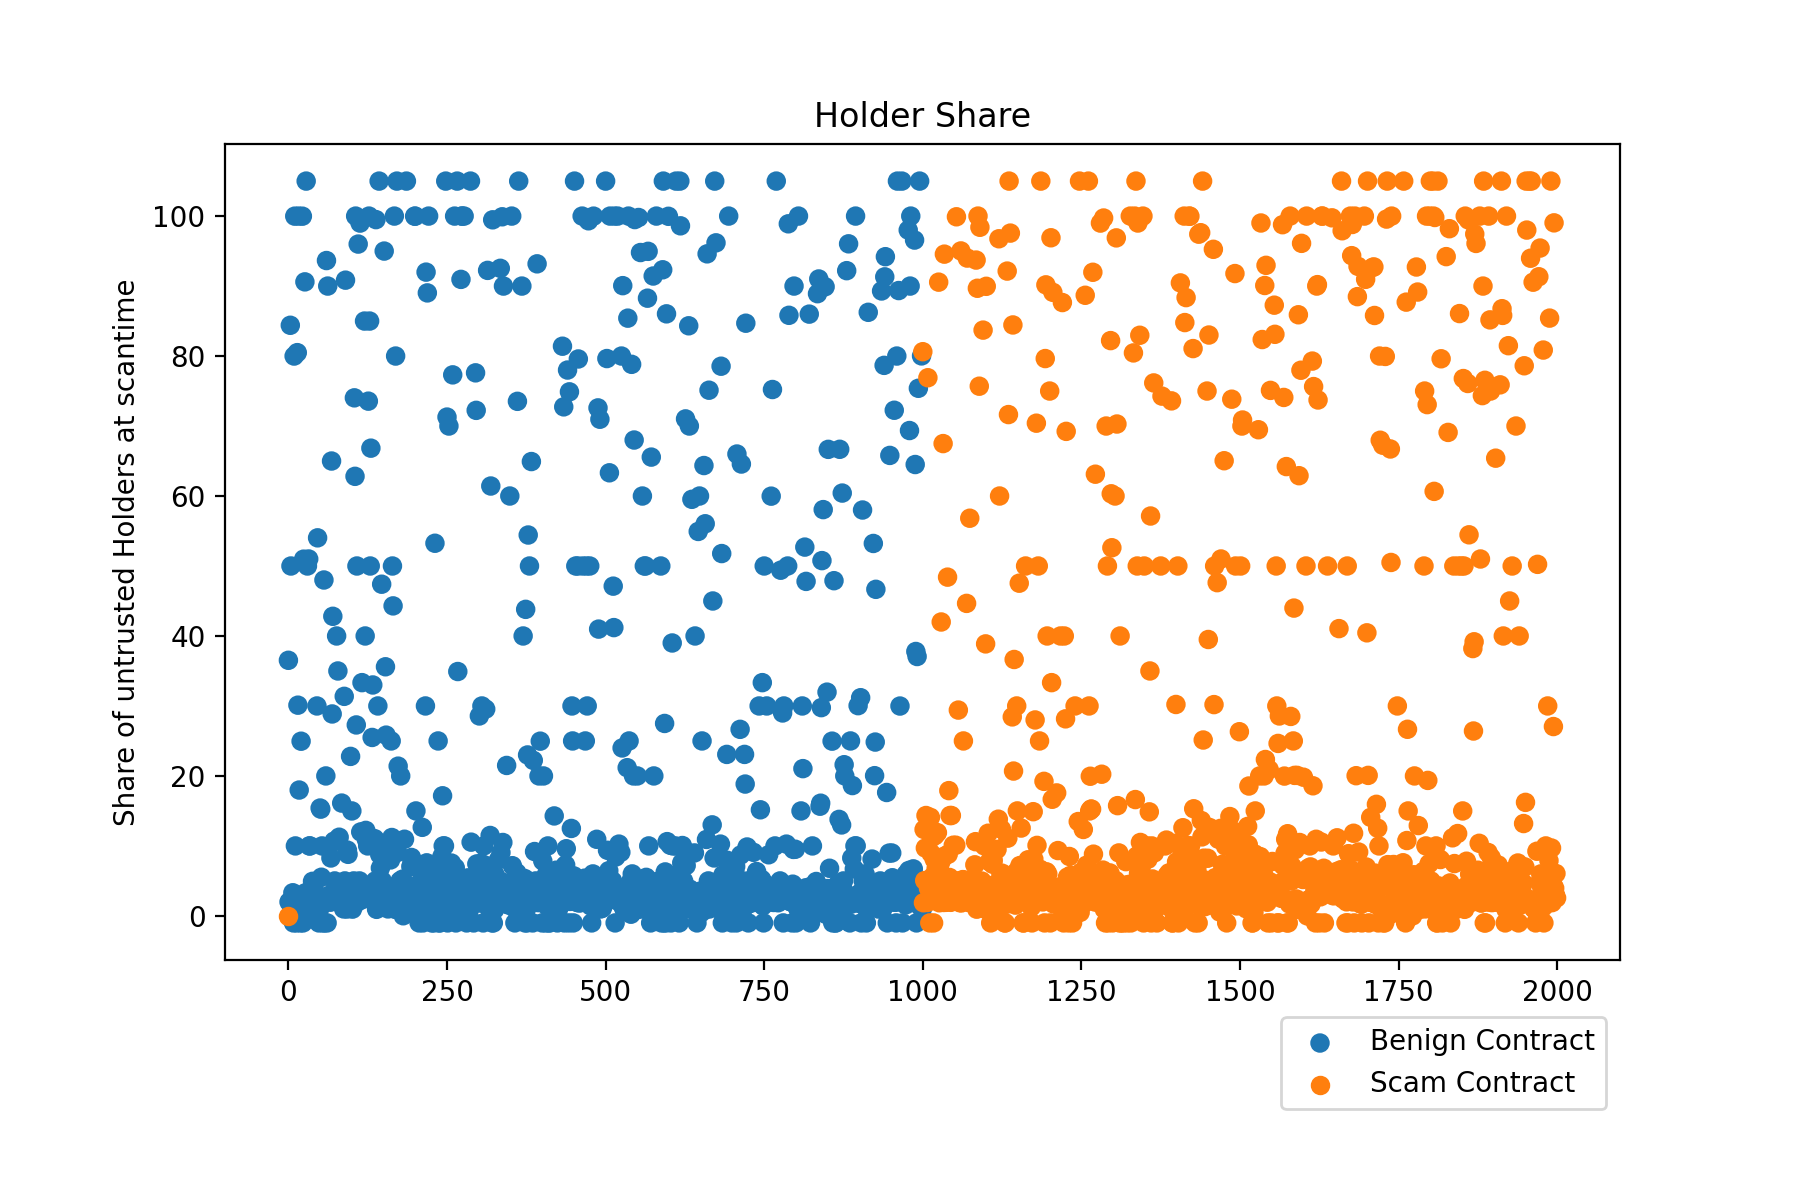

In [4]:

%matplotlib notebook
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('legend', fontsize=18)    # legend fontsize

fig, ax = plt.subplots(figsize =(9, 6))

ax.scatter(df_holder_share_values['x'], df_holder_share_values['y'] , c=plot_colors, label="Benign Contract") #label=annotations)
ax.scatter(0, 0 , c=colors[1], label="Scam Contract")
plt.legend(loc=4, bbox_to_anchor=(1,-0.2))
plt.ylabel("Share of untrusted Holders at scantime")
plt.title("Holder Share")
plt.subplots_adjust(bottom=0.2)
plt.show()


In [32]:
%matplotlib notebook
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('legend', fontsize=18)    # legend fontsize

fig, ax = plt.subplots(figsize =(9, 6))
bins = np.arange(0,100,1)

plt.hist((holder_share_benign, holder_share_scam), bins=bins, label=('Benign Contract','Scam Contract'))
plt.ylabel("Amount of Contracts")
plt.xlabel("Highest Token Holder Share [%]")
plt.legend()
plt.title("Holder Share")
plt.savefig('token_holder_share_0_100.pdf')


<IPython.core.display.Javascript object>

In [33]:
%matplotlib notebook
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('legend', fontsize=18)    # legend fontsize

fig, ax = plt.subplots(figsize =(9, 6))
bins = np.arange(0,20,0.5)

plt.hist((holder_share_benign, holder_share_scam), bins=bins, label=('Benign Contract','Scam Contract'))
plt.ylabel("Amount of Contracts")
plt.xlabel("Highest Token Holder Share [%]")
plt.legend()
plt.title("Holder Share")
plt.savefig('token_holder_share_0_20.pdf')


<IPython.core.display.Javascript object>

(329, 671, 289, 711)
0.5323624595469256


<IPython.core.display.Javascript object>


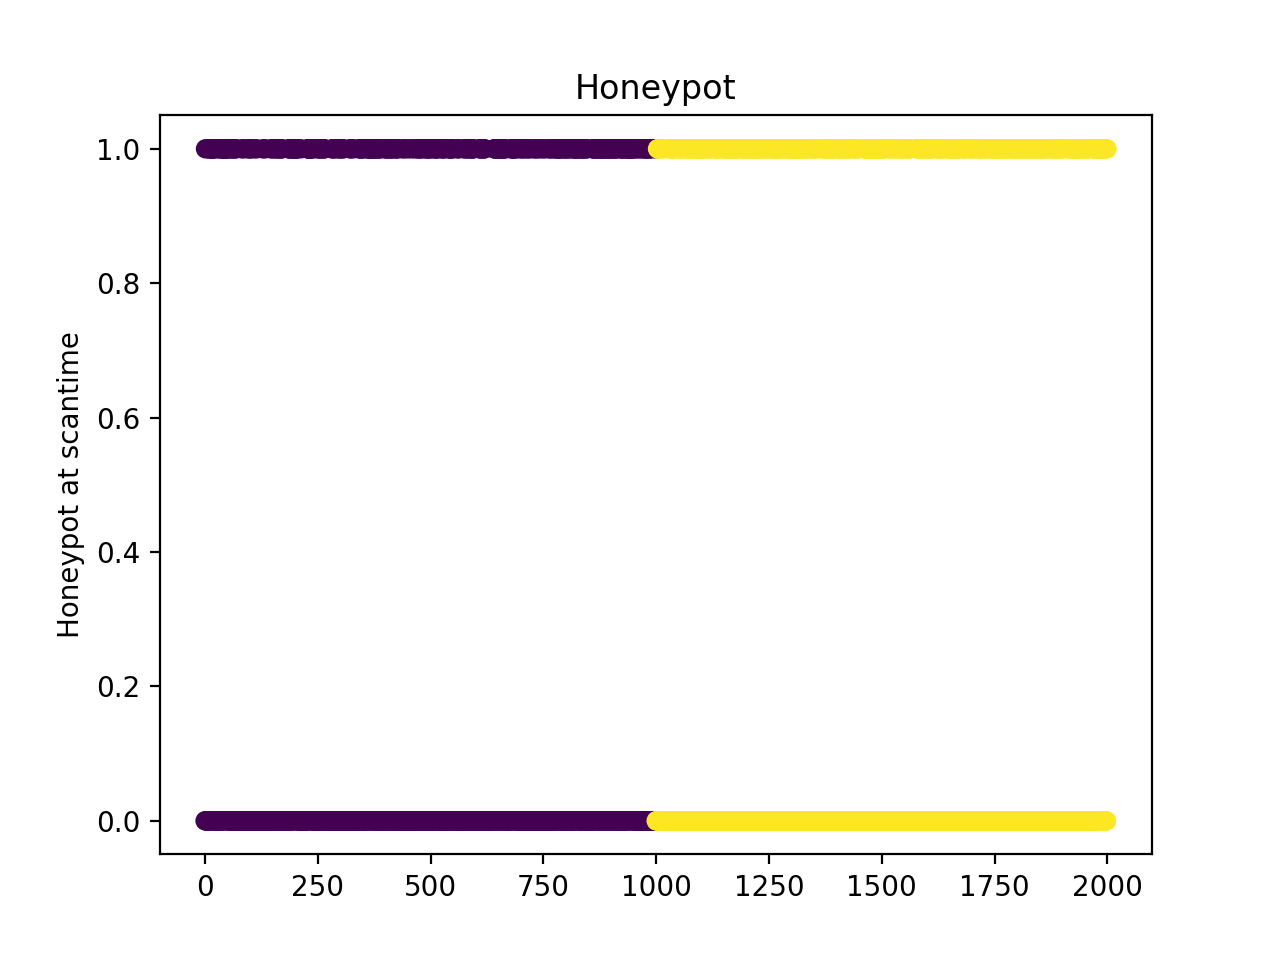

Text(0.5, 1.0, 'Honeypot')

In [51]:
honeypot_values = []
annotations = []
numbers = []

honeypot_scam_counter = 0
no_honeypot_scam_counter = 0
honeypot_benign_counter = 0
no_honeypot_benign_counter = 0

for index, entry in data.iterrows():
    token = scam_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    
    honeypot = token['honeypot']['IsHoneypot']

    if honeypot is True:
        honeypot_values.append(1)
    else:
        honeypot_values.append(0)
        
    annotations.append(entry['scam'])
    numbers.append(index)
    if entry['scam'] == 1:
        if honeypot:
            honeypot_scam_counter += 1
        else:
            no_honeypot_scam_counter += 1
    else:
        if honeypot:
            honeypot_benign_counter += 1
        else:
            no_honeypot_benign_counter += 1    
            

print((honeypot_scam_counter, no_honeypot_scam_counter, honeypot_benign_counter, no_honeypot_benign_counter))
print( 1.0/ (honeypot_benign_counter + honeypot_scam_counter) * honeypot_scam_counter )

# print(honeypot_values)
# print(annotations)
df = pd.DataFrame(honeypot_values)
%matplotlib notebook

plt.scatter(numbers, honeypot_values , c=annotations) #label=annotations)
plt.ylabel("Honeypot at scantime")
plt.title("Honeypot")

# anderes format
# vertikal balken kummuliert


<IPython.core.display.Javascript object>


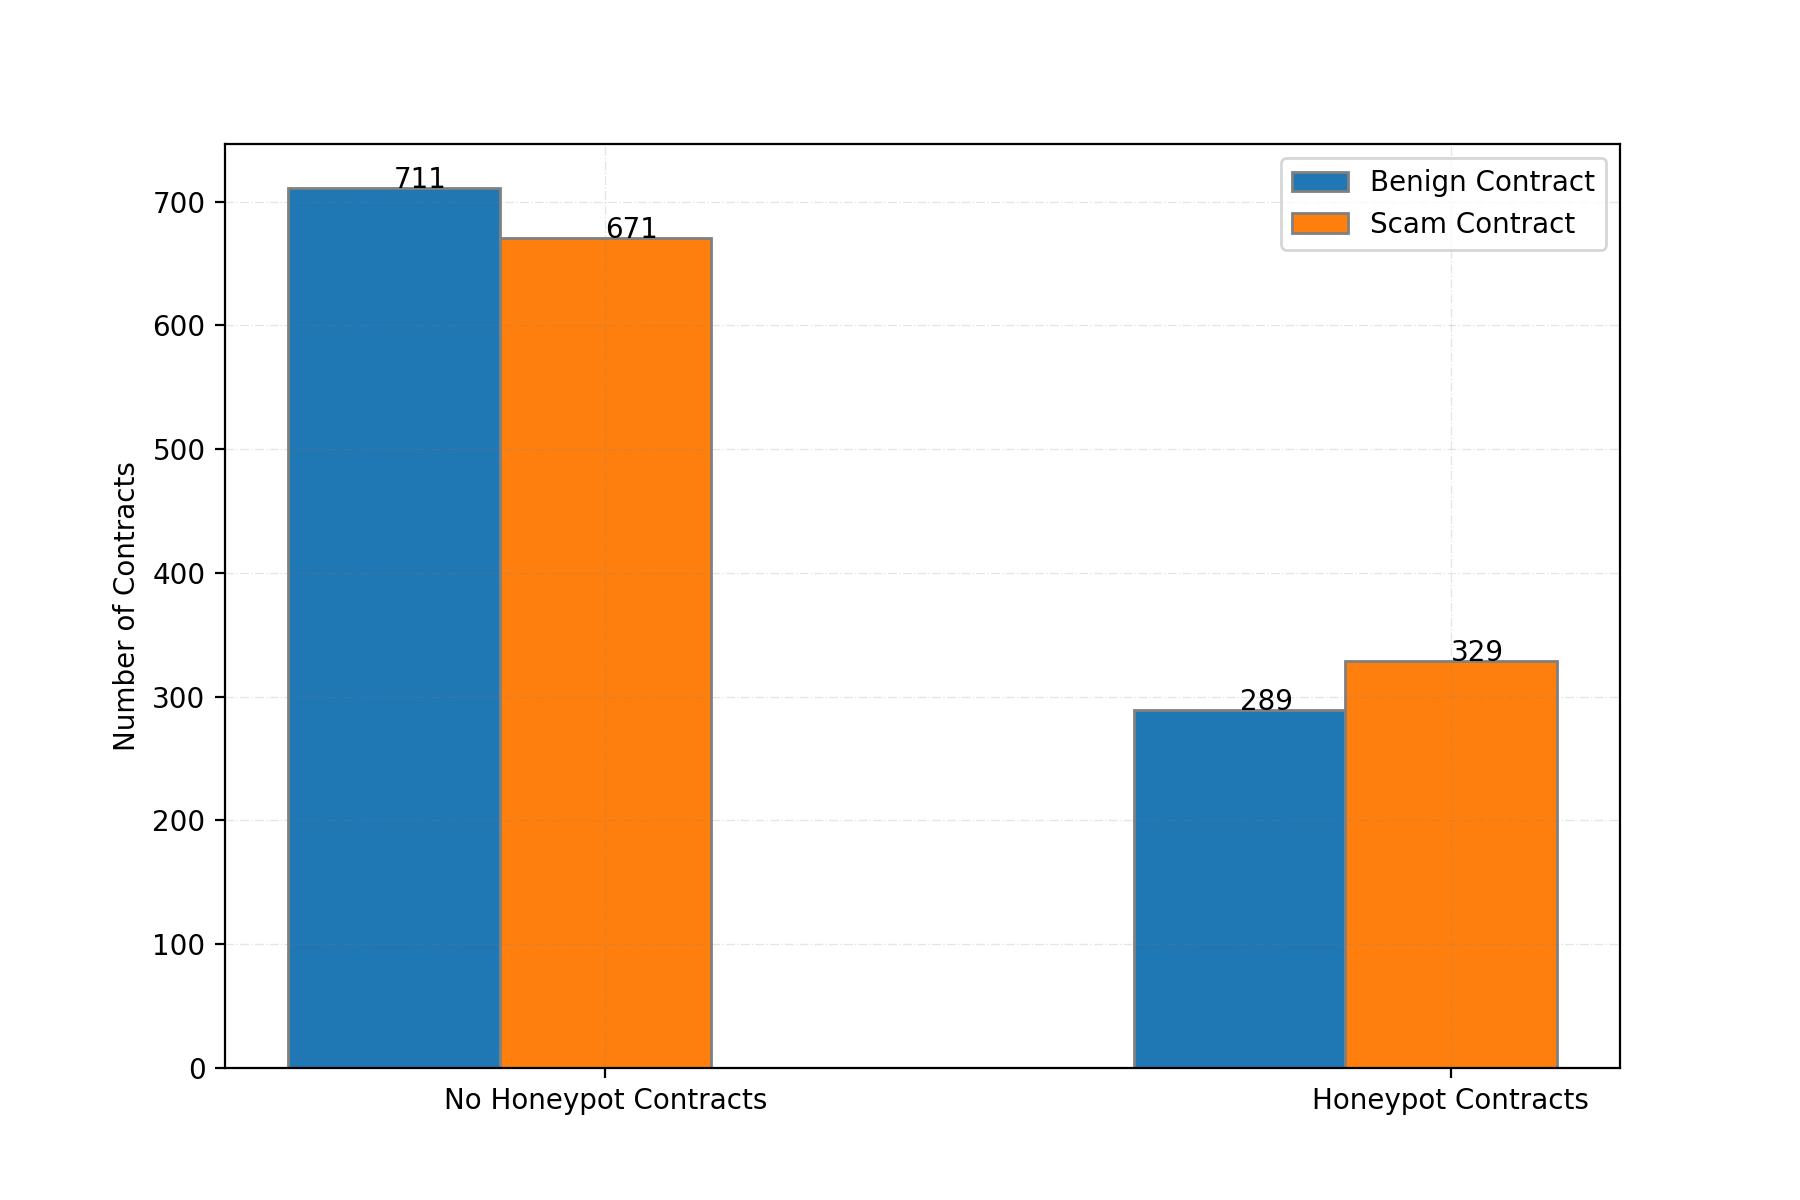

In [52]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i],y[i],y[i])

%matplotlib notebook
fig, ax = plt.subplots(figsize =(9, 6))

barWidth = 0.25

br1 = np.arange(2)
br2 = [x + barWidth for x in br1]

plt.bar(br1, [no_honeypot_benign_counter, honeypot_benign_counter], width = barWidth,
        edgecolor ='grey', label ='Benign Contract')



plt.bar(br2, [no_honeypot_scam_counter, honeypot_scam_counter], width = barWidth,
        edgecolor ='grey', label ='Scam Contract')

addlabels(br1, [no_honeypot_benign_counter, honeypot_benign_counter])

addlabels(br2, [no_honeypot_scam_counter, honeypot_scam_counter])


# plt.xlabel('', fontweight ='bold', fontsize = 15)
plt.ylabel('Number of Contracts')
plt.xticks([r + barWidth for r in range(2)],
        ['No Honeypot Contracts', 'Honeypot Contracts'])
 
ax.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)


plt.legend()
plt.show()

In [53]:
honeypot_buy_fees_values = []
annotations = []
numbers = []

for index, entry in data.iterrows():
    token = scam_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    
    honeypot_buy_fee = float(token['honeypot']['BuyTax'])
    
    honeypot_buy_fees_values.append(honeypot_buy_fee)
        
    annotations.append(entry['scam'])
    numbers.append(index)
        
# print(honeypot_buy_fees_values)
# print(annotations)
df = pd.DataFrame(honeypot_buy_fees_values)
%matplotlib notebook
plt.scatter(numbers, honeypot_buy_fees_values , c=annotations) #label=annotations)
plt.ylabel("Honeypot BuyFee at scantime")
plt.title("Honeypot BuyFee")

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Honeypot BuyFee')

In [55]:
honeypot_sell_fees_values = []
annotations = []
numbers = []

for index, entry in data.iterrows():
    token = scam_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    
    honeypot_sell_fee = float(token['honeypot']['SellTax'])
    
    honeypot_sell_fees_values.append(honeypot_sell_fee)
        
    annotations.append(entry['scam'])
    numbers.append(index)
        
# print(honeypot_sell_fees_values)
# print(annotations)
df = pd.DataFrame(honeypot_sell_fees_values)
%matplotlib notebook
plt.scatter(numbers, honeypot_sell_fees_values , c=annotations) #label=annotations)
plt.ylabel("Honeypot SellFee at scantime")
plt.title("Honeypot SellFee")

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Honeypot SellFee')

In [34]:
ownership_values = []
annotations = []
numbers = []
ownership_scam = []
ownership_benign = []

ownership_scam_counter = 0
ownership_benign_counter = 0
no_ownership_scam_counter = 0
no_ownership_benign_counter = 0
renounced_ownership_scam_counter = 0
renounced_ownership_benign_counter = 0

for index, entry in data.iterrows():
    token = scam_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    
    evaluator = Evaluator(token, evaluation.evaluation_config.DEFAULT_CONFIG)            
    
    ownership_renounced = evaluator.get_renounced_ownership()

    if ownership_renounced is None:
        ownership_values.append(-1)
        if entry['scam'] == 1:
            ownership_scam.append(-1)
            no_ownership_scam_counter += 1
        else:
            ownership_benign.append(-1)
            no_ownership_benign_counter += 1
    elif ownership_renounced == 0.0:
        ownership_values.append(0)
        if entry['scam'] == 1:
            ownership_scam.append(0)
            renounced_ownership_scam_counter += 1
        else:
            ownership_benign.append(0)
            renounced_ownership_benign_counter += 1
    else:
        ownership_values.append(1)
        if entry['scam'] == 1:
            ownership_scam.append(1)
            ownership_scam_counter += 1
        else:
            ownership_benign.append(1)
            ownership_benign_counter +=1
            
    annotations.append(entry['scam'])
    numbers.append(index)
        
# print(ownership_values)
# print(annotations)
df = pd.DataFrame(ownership_values)
%matplotlib notebook
plt.scatter(numbers, ownership_values , c=annotations) #label=annotations)
plt.ylabel("Ownership at scantime")
plt.title("Ownership")

# vertikal balken diagramm

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Ownership')

In [56]:
%matplotlib notebook

plt.hist((ownership_benign,ownership_scam))
plt.title("Ownership")
plt.show()

<IPython.core.display.Javascript object>

In [75]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i]-0.05,y[i]+1,y[i])


        
%matplotlib notebook
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('legend', fontsize=18)    # legend fontsize

fig, ax = plt.subplots(figsize =(9, 6))

barWidth = 0.4

br1 = np.arange(3)
br2 = [x + barWidth for x in br1]


plt.bar(br1, [renounced_ownership_benign_counter, ownership_benign_counter, no_ownership_benign_counter], width = barWidth,
        edgecolor ='grey', label ='Benign Contract')



plt.bar(br2, [renounced_ownership_scam_counter, ownership_scam_counter, no_ownership_scam_counter], width = barWidth,
        edgecolor ='grey', label ='Scam Contract')

addlabels(br1, [renounced_ownership_benign_counter, ownership_benign_counter, no_ownership_benign_counter])

addlabels(br2, [renounced_ownership_scam_counter, ownership_scam_counter, no_ownership_scam_counter])


# plt.xlabel('', fontweight ='bold', fontsize = 15)
plt.ylabel('Number of Contracts')
plt.xticks([r + barWidth for r in range(3)],
        ['Renounced', 'Not renounced', 'Not found'])
 
plt.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)


plt.legend()
plt.savefig("ownership_distribution.pdf")
plt.show()

<IPython.core.display.Javascript object>

(856, 144, 769, 231)
0.384


<IPython.core.display.Javascript object>


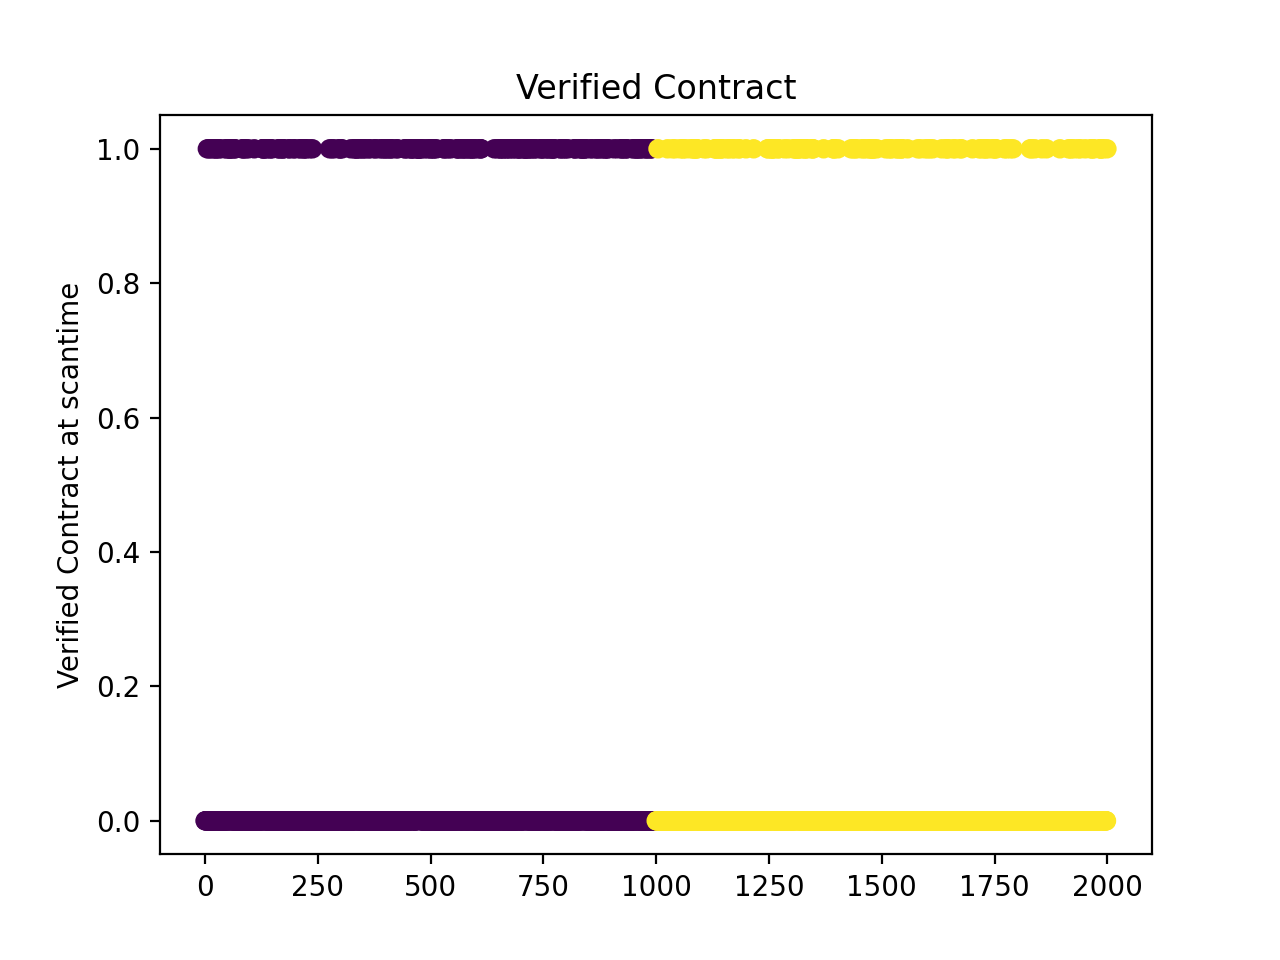

In [49]:
verified_contract_values = []
annotations = []
numbers = []

verified_scam_counter = 0
verified_benign_counter = 0
unverified_scam_counter = 0
unverified_benign_counter = 0

for index, entry in data.iterrows():
    token = scam_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    
    evaluator = Evaluator(token, evaluation.evaluation_config.DEFAULT_CONFIG)            
    
    verified_contract = evaluator.get_verified_contract()

    if verified_contract:
        verified_contract_values.append(0)
    else:
        verified_contract_values.append(1)
        
    annotations.append(entry['scam'])
    numbers.append(index)
    
    if entry['scam'] == 1:
        if verified_contract:
            verified_scam_counter += 1
        else:
            unverified_scam_counter += 1
    else:
        if verified_contract:
            verified_benign_counter += 1
        else:
            unverified_benign_counter += 1        
        
print((verified_scam_counter, unverified_scam_counter, verified_benign_counter, unverified_benign_counter))
print( 1.0/ (unverified_benign_counter + unverified_scam_counter) * unverified_scam_counter )
# print(verified_contract_values)
# print(annotations)

%matplotlib notebook
plt.scatter(numbers, verified_contract_values , c=annotations) #label=annotations)
plt.ylabel("Verified Contract at scantime")
plt.title("Verified Contract")
plt.show()


<IPython.core.display.Javascript object>


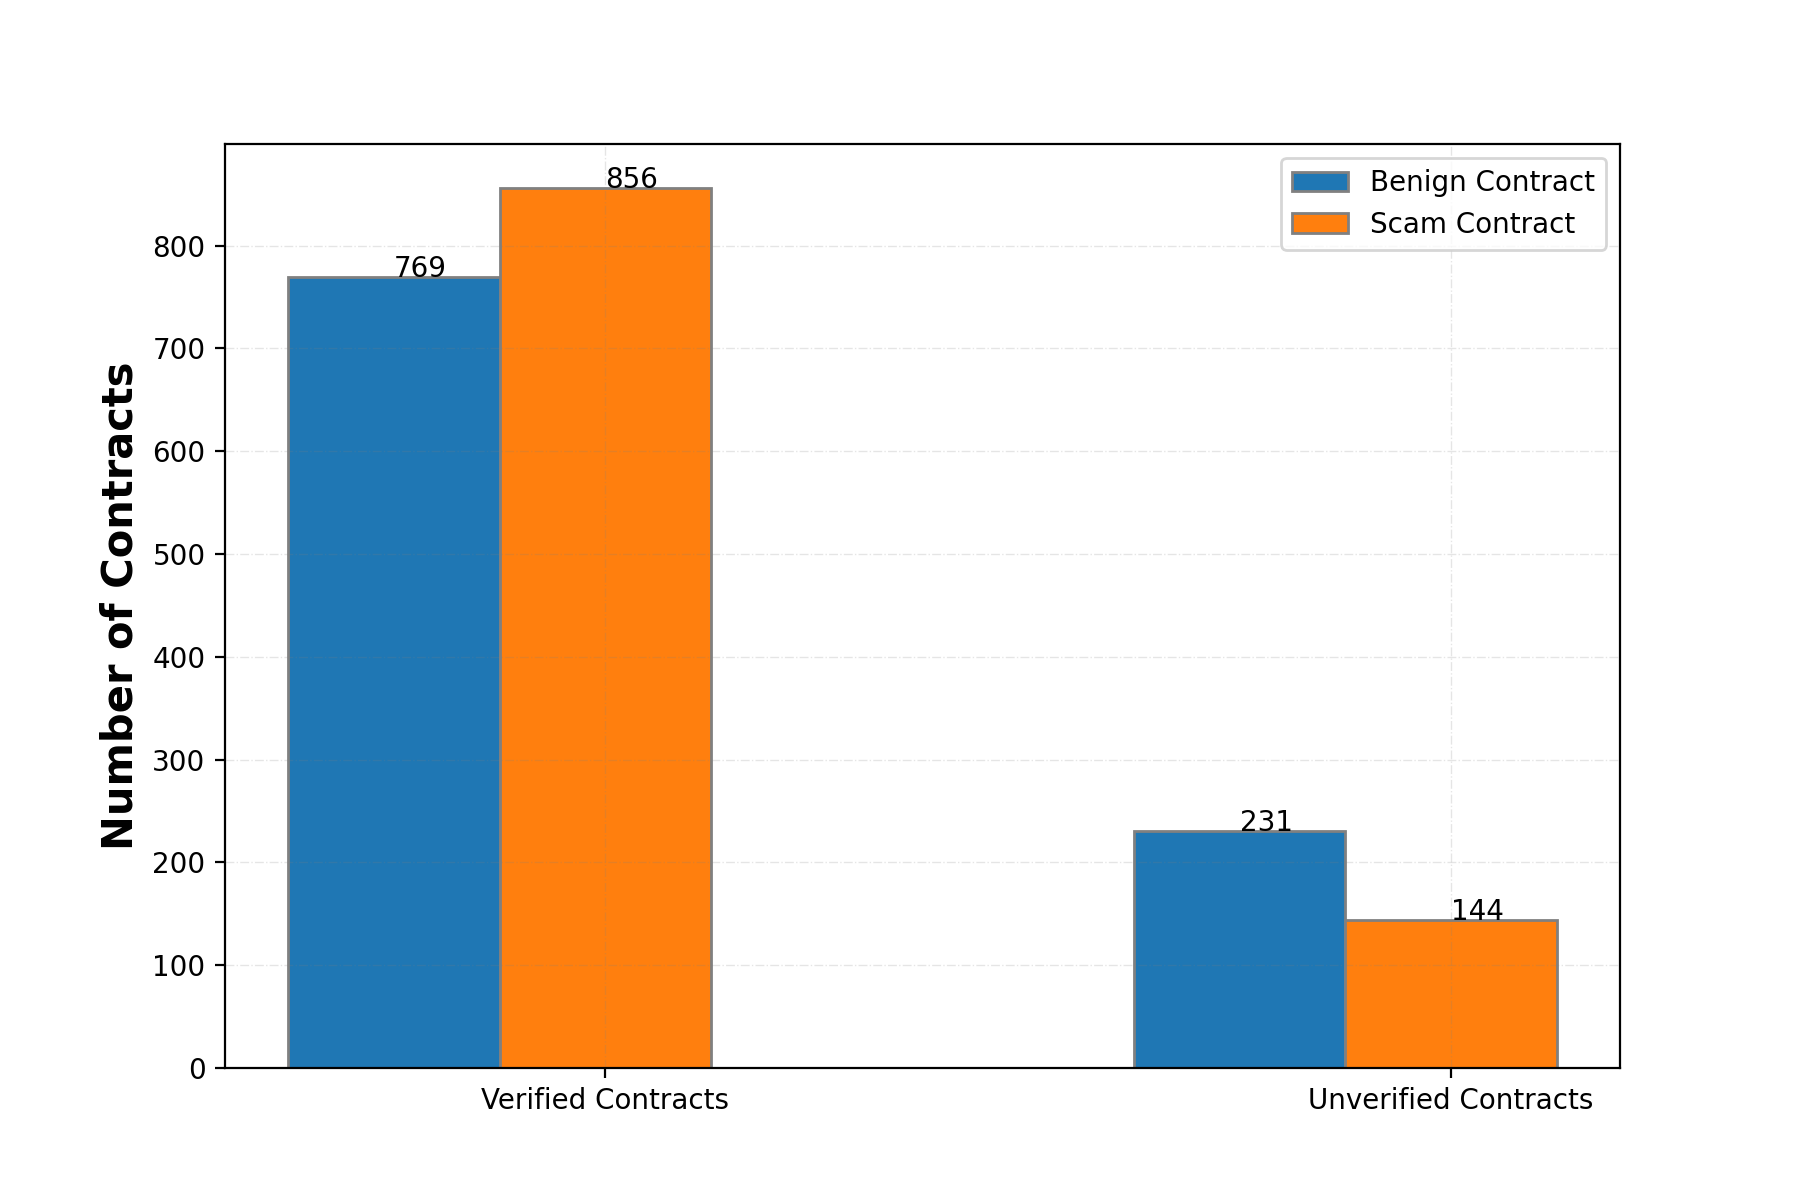

In [50]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i],y[i],y[i])

%matplotlib notebook
fig, ax = plt.subplots(figsize =(9, 6))

barWidth = 0.25

br1 = np.arange(2)
br2 = [x + barWidth for x in br1]

plt.bar(br1, [verified_benign_counter, unverified_benign_counter], width = barWidth,
        edgecolor ='grey', label ='Benign Contract')



plt.bar(br2, [verified_scam_counter, unverified_scam_counter], width = barWidth,
        edgecolor ='grey', label ='Scam Contract')

addlabels(br1, [verified_benign_counter, unverified_benign_counter])

addlabels(br2, [verified_scam_counter, unverified_scam_counter])


# plt.xlabel('', fontweight ='bold', fontsize = 15)
plt.ylabel('Number of Contracts', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(2)],
        ['Verified Contracts', 'Unverified Contracts'])
 
ax.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)


plt.legend()
plt.show()

<IPython.core.display.Javascript object>


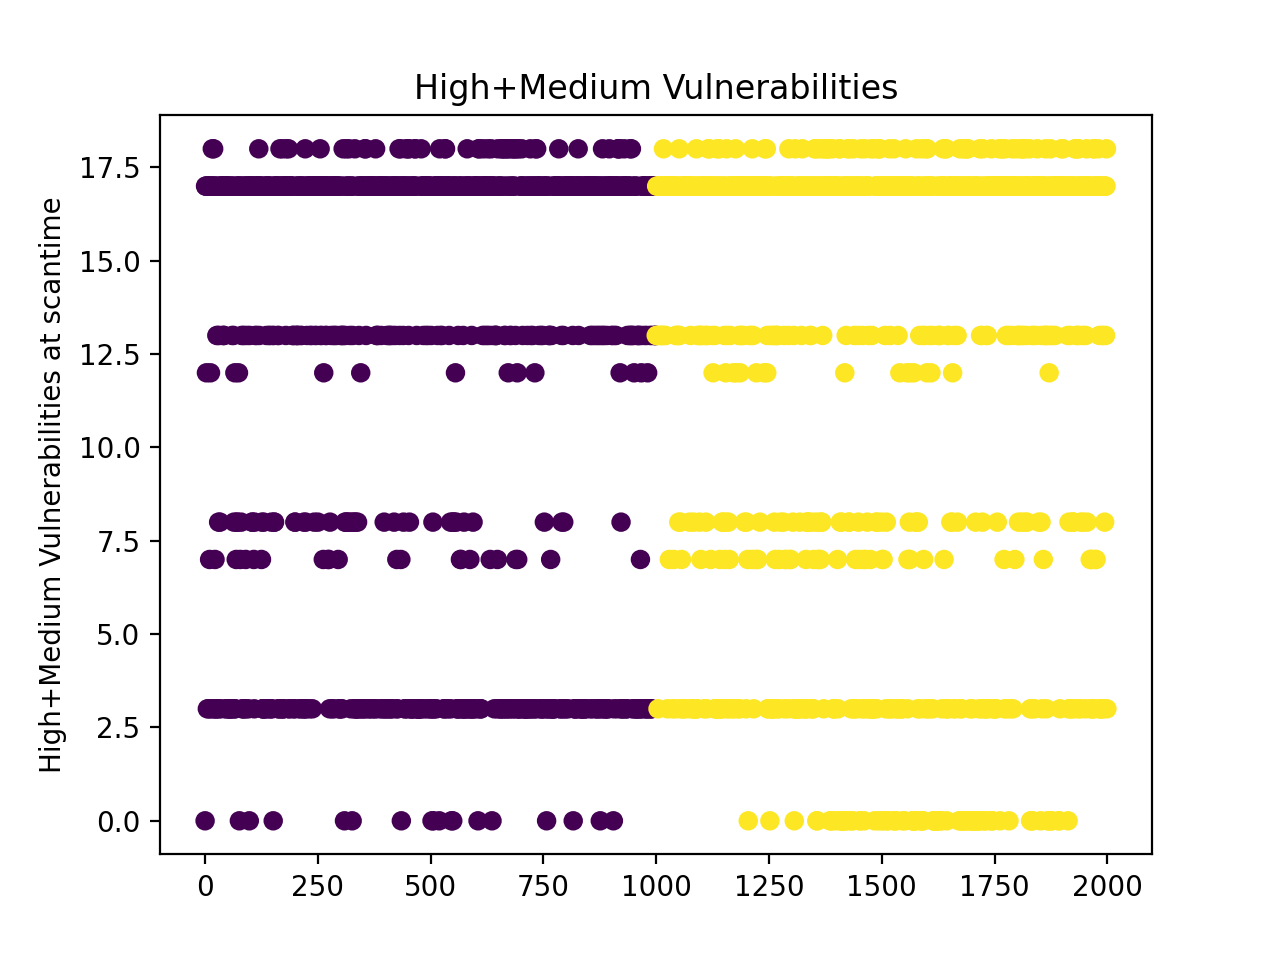

Text(0.5, 1.0, 'High+Medium Vulnerabilities')

In [161]:
slither_high_values = []
annotations = []
numbers = []

scam_vulns = []
benign_vulns = []

benign_vuln_high_counter = 0
scam_vuln_high_counter = 0

benign_vuln_medium_counter = 0
scam_vuln_medium_counter = 0

benign_vuln_invalid_counter = 0
scam_vuln_invalid_counter = 0


for index, entry in data.iterrows():
    token = scam_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    
#     slither_results = token['verified_contract']['slither_results']
    numbers.append(index)
    annotations.append(entry['scam'])

    evaluator = Evaluator(token, evaluation.evaluation_config.DEFAULT_CONFIG)            
    
    impact, confidence = evaluator.get_highest_vulnerability()
    
    if impact is None:
        slither_high_values.append(-1)
        continue
    
    slither_high_values.append((impact*5+confidence))
    
    if entry['scam'] == 1:
        if verified_contract:
            verified_scam_counter += 1
        else:
            unverified_scam_counter += 1
    else:
        if verified_contract:
            verified_benign_counter += 1
        else:
            unverified_benign_counter += 1        

    
    if entry['scam'] == 1:
        scam_vulns.append((impact*5+confidence))
    else:
        benign_vulns.append((impact*5+confidence))
    
#     if slither_results['error'] == 1:
#         slither_high_values.append(-1)
#         continue
    
#     high_found = None
#     reentrancy_found = None

#     for vuln in slither_results['vulnerabilities']:     
#         if vuln['impact'] in ["High"] and vuln['confidence'] in ["High"]:
#             high_found = True
#         if vuln['check'] == "reentrancy-eth":
#             reentrancy_found = True


#     if high_found is True:
#         slither_high_values.append(1)
#     elif reentrancy_found:
#         slither_high_values.append(0.5)

#     else:
#         slither_high_values.append(0)
    
# print(len(slither_high_values))
# print(len(annotations))

df = pd.DataFrame(slither_high_values)
%matplotlib notebook
plt.scatter(numbers, slither_high_values , c=annotations) #label=annotations)
plt.ylabel("High+Medium Vulnerabilities at scantime")
plt.title("High+Medium Vulnerabilities")

# vertikal balken


<IPython.core.display.Javascript object>


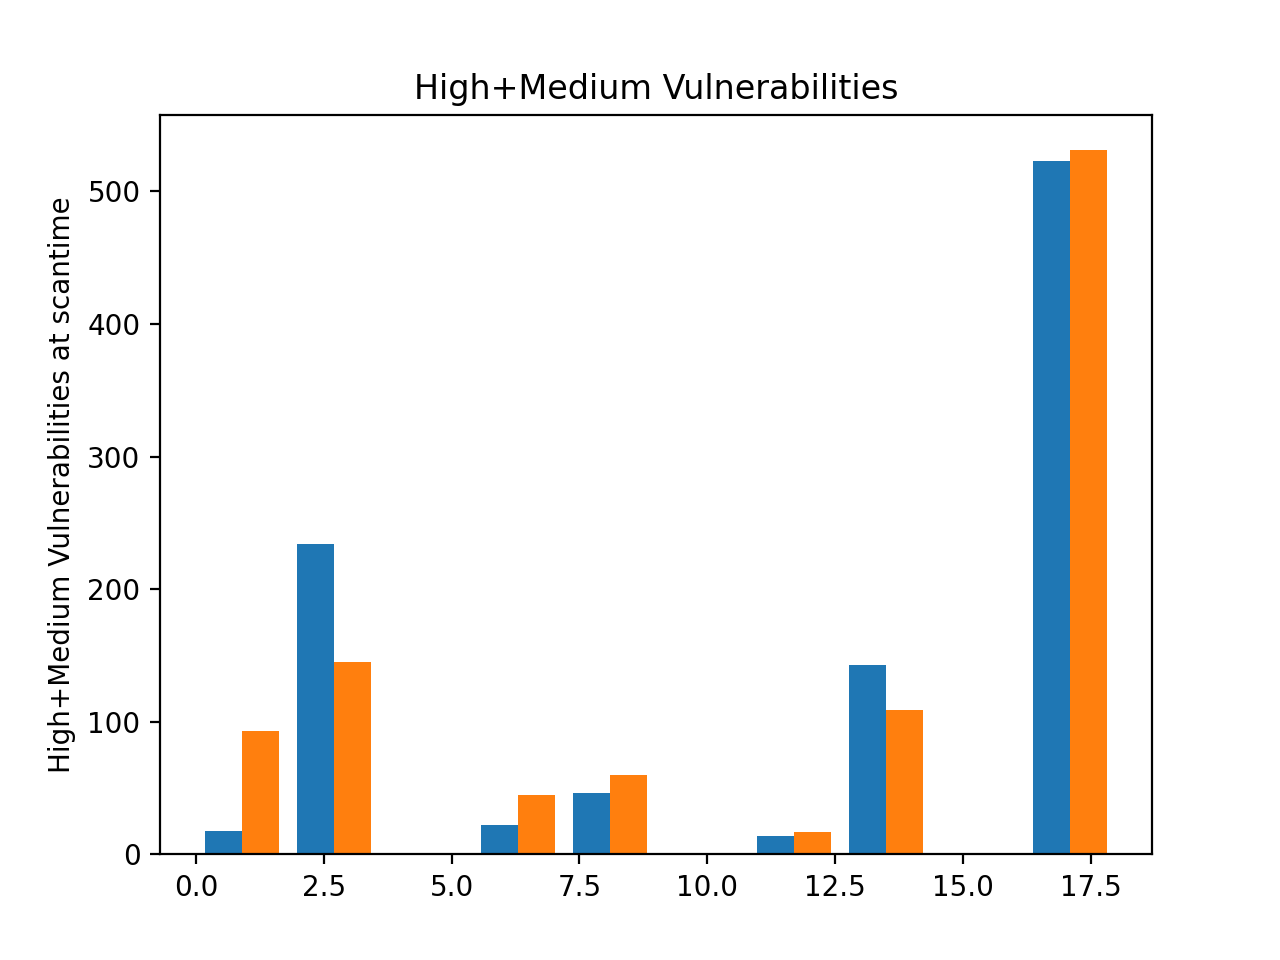

Text(0.5, 1.0, 'High+Medium Vulnerabilities')

In [162]:
%matplotlib notebook
plt.hist((benign_vulns, scam_vulns)) #label=annotations)
plt.ylabel("High+Medium Vulnerabilities at scantime")
plt.title("High+Medium Vulnerabilities")

In [45]:
slither_high_values = []
annotations = []
numbers = []

vuln_types_benign = {
    "abiencoderv2-array": 0,
    "array-by-reference": 0,
    "incorrect-shift": 0,
    "multiple-constructors": 0,
    "name-reused": 0,
    "public-mappings-nested": 0,
    "rtlo": 0,
    "shadowing-state": 0,
    "suicidal": 0,
    "uninitialized-state": 0,
    "uninitialized-storage": 0,
    "unprotected-upgrade": 0,
    "arbitrary-send": 0,
    "controlled-array-length": 0,
    "controlled-delegatecall": 0,
    "delegatecall-loop": 0,
    "msg-value-loop": 0,
    "reentrancy-eth": 0,
    "storage-array": 0,
    "unchecked-transfer": 0,
    "weak-prng": 0,
    "enum-conversion": 0,
    "erc20-interface": 0,
    "erc721-interface": 0,
    "incorrect-equality": 0,
    "locked-ether": 0,
    "mapping-deletion": 0,
    "shadowing-abstract": 0,
    "tautology": 0,
    "write-after-write": 0,
    "boolean-cst": 0,
    "constant-function-asm": 0,
    "constant-function-state": 0,
    "divide-before-multiply": 0,
    "reentrancy-no-eth": 0,
    "reused-constructor": 0,
    "tx-origin": 0,
    "unchecked-lowlevel": 0,
    "unchecked-send": 0,
    "uninitialized-local": 0,
    "unused-return": 0,
    "incorrect-modifier": 0,
    "shadowing-builtin": 0,
    "shadowing-local": 0,
    "uninitialized-fptr-cst": 0,
    "variable-scope": 0,
    "void-cst": 0,
    "calls-loop": 0,
    "events-access": 0,
    "events-maths": 0,
    "incorrect-unary": 0,
    "missing-zero-check": 0,
    "reentrancy-benign": 0,
    "reentrancy-events": 0,
    "timestamp": 0,
}

vuln_types_scam = {
    "abiencoderv2-array": 0,
    "array-by-reference": 0,
    "incorrect-shift": 0,
    "multiple-constructors": 0,
    "name-reused": 0,
    "public-mappings-nested": 0,
    "rtlo": 0,
    "shadowing-state": 0,
    "suicidal": 0,
    "uninitialized-state": 0,
    "uninitialized-storage": 0,
    "unprotected-upgrade": 0,
    "arbitrary-send": 0,
    "controlled-array-length": 0,
    "controlled-delegatecall": 0,
    "delegatecall-loop": 0,
    "msg-value-loop": 0,
    "reentrancy-eth": 0,
    "storage-array": 0,
    "unchecked-transfer": 0,
    "weak-prng": 0,
    "enum-conversion": 0,
    "erc20-interface": 0,
    "erc721-interface": 0,
    "incorrect-equality": 0,
    "locked-ether": 0,
    "mapping-deletion": 0,
    "shadowing-abstract": 0,
    "tautology": 0,
    "write-after-write": 0,
    "boolean-cst": 0,
    "constant-function-asm": 0,
    "constant-function-state": 0,
    "divide-before-multiply": 0,
    "reentrancy-no-eth": 0,
    "reused-constructor": 0,
    "tx-origin": 0,
    "unchecked-lowlevel": 0,
    "unchecked-send": 0,
    "uninitialized-local": 0,
    "unused-return": 0,
    "incorrect-modifier": 0,
    "shadowing-builtin": 0,
    "shadowing-local": 0,
    "uninitialized-fptr-cst": 0,
    "variable-scope": 0,
    "void-cst": 0,
    "calls-loop": 0,
    "events-access": 0,
    "events-maths": 0,
    "incorrect-unary": 0,
    "missing-zero-check": 0,
    "reentrancy-benign": 0,
    "reentrancy-events": 0,
    "timestamp": 0,
}


for index, entry in data.iterrows():
    token = scam_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    
    slither_results = token['verified_contract']['slither_results']
    annotations.append(entry['scam'])
#     if entry['Scam'] == 1:
#         numbers.append(index+200)
#     else:
#         numbers.append(index)
    numbers.append(index)

    
    if slither_results['error'] == 1:
        slither_high_values.append(-1)
        continue
    
    high_found = None
    unique_list = []
    for vuln in slither_results['vulnerabilities']:
        if vuln['check'] in unique_list:
            continue
            
        unique_list.append(vuln['check'])
        
        if entry['scam'] == 1:
            vuln_types_scam[vuln['check']] += 1 
        else:
            vuln_types_benign[vuln['check']] += 1 


    if high_found is True:
        slither_high_values.append(1)
    else:
        slither_high_values.append(0)

# print(vuln_types_scam)
# print(vuln_types_benign)
print(len(slither_high_values))
print(len(annotations))

# %matplotlib notebook
# plt.scatter(numbers, slither_high_values , c=annotations) #label=annotations)
# plt.ylabel("Reentrancy Vulnerabilities at scantime")
# plt.title("Reentrancy Vulnerabilities")




2000
2000


In [66]:
%matplotlib notebook
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('legend', fontsize=18)    # legend fontsize

def addlabels(x,y,text):
    for i in range(len(x)):
        plt.text(y[i]+2, x[i], text[i], va="center", ha='left')

# print(vuln_types_scam)
# print(vuln_types_benign)


vuln_types_scam_keys = list(vuln_types_scam.keys())
vuln_types_benign_keys = list(vuln_types_benign.keys())
vuln_types_scam_values = list(vuln_types_scam.values())
vuln_types_benign_values = list(vuln_types_benign.values())

importance = []

for i in range(len(vuln_types_benign_keys)):
    try:
        importance.append("{:.2f} % Scam".format(100/(vuln_types_benign_values[i] + vuln_types_scam_values[i])*vuln_types_scam_values[i]))
    except:
        importance.append("")

        
# print(importance)
fig, ax = plt.subplots(figsize =(9, 16))

plt.subplots_adjust(left=0.4)


plt.barh(vuln_types_benign_keys, vuln_types_benign_values,)
plt.barh(vuln_types_scam_keys, vuln_types_scam_values, left=vuln_types_benign_values)

addlabels(vuln_types_scam_keys, list(vuln_types_benign_values + vuln_types_scam_values), importance)
scam_labels = ['Benign Contract', 'Scam Contract']
plt.legend(scam_labels)
plt.savefig('vulnerabilitiy_distribution.pdf')  
plt.show()

# (vuln_types_benign_values + vuln_types_scam_values)


<IPython.core.display.Javascript object>

In [68]:
importance = []
for i in range(len(vuln_types_benign_keys)):
    try:
        importance.append((vuln_types_benign_keys[i], 100/(vuln_types_benign_values[i] + vuln_types_scam_values[i])*vuln_types_scam_values[i],vuln_types_benign_values[i]+ vuln_types_scam_values[i] ))
    except:
        importance.append((vuln_types_benign_keys[i], None, None))

df_importance = pd.DataFrame(importance)
df_importance

0           1       2
0        abiencoderv2-array         NaN     NaN
1        array-by-reference         NaN     NaN
2           incorrect-shift         NaN     NaN
3     multiple-constructors         NaN     NaN
4               name-reused         NaN     NaN
5    public-mappings-nested         NaN     NaN
6                      rtlo         NaN     NaN
7           shadowing-state   30.434783    23.0
8                  suicidal         NaN     NaN
9       uninitialized-state   62.393162   117.0
10    uninitialized-storage         NaN     NaN
11      unprotected-upgrade         NaN     NaN
12           arbitrary-send   37.192982   285.0
13  controlled-array-length    0.000000     1.0
14  controlled-delegatecall  100.000000    21.0
15        delegatecall-loop         NaN     NaN
16           msg-value-loop         NaN     NaN
17           reentrancy-eth   44.965278  1152.0
18            storage-array         NaN     NaN
19       unchecked-transfer   36.633663   101.0
20                weak-prng    0.000000     1.0
21          enum-conversion         NaN     NaN
22          erc20-interface   50.000000     2.0
23         erc721-interface         NaN     NaN
24       incorrect-equality   47.569444   288.0
25             locked-ether   71.794872    39.0
26         mapping-deletion         NaN     NaN
27       shadowing-abstract         NaN     NaN
28                tautology   34.928230   209.0
29        write-after-write   31.250000    64.0
30              boolean-cst         NaN     NaN
31    constant-function-asm    0.000000     1.0
32  constant-function-state         NaN     NaN
33   divide-before-multiply   35.676626   569.0
34        reentrancy-no-eth   25.552826   407.0
35       reused-constructor         NaN     NaN
36                tx-origin   28.808864   361.0
37       unchecked-lowlevel   75.757576    33.0
38           unchecked-send  100.000000     1.0
39      uninitialized-local   31.944444    72.0
40            unused-return   43.355120   918.0
41       incorrect-modifier    0.000000     7.0
42        shadowing-builtin    0.000000     1.0
43          shadowing-local   51.491966  1307.0
44   uninitialized-fptr-cst         NaN     NaN
45           variable-scope   63.380282    71.0
46                 void-cst         NaN     NaN
47               calls-loop   22.222222   162.0
48            events-access   86.956522    46.0
49             events-maths   43.320236  1018.0
50          incorrect-unary         NaN     NaN
51       missing-zero-check   40.895522   670.0
52        reentrancy-benign   45.304348  1150.0
53        reentrancy-events   44.152542  1180.0
54                timestamp   48.095910   709.0

In [69]:
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
import joblib
%matplotlib notebook

trainset_numbers = []
trainset_scores = []
trainset_annotations = []

train_scam_data = []
train_benign_data = []

test_scam_data = []
test_benign_data = []

for index, entry in data.iterrows():
    token = scam_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    if token is None:
        token = big_dataset_50_50_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
        if token is None:
            print(entry['address'])

    evaluator = Evaluator(token, evaluation.evaluation_config.DEFAULT_CONFIG)
    result, final_result = evaluator.get_score()
#     print(result)
#     print(final_result)
#     print(entry['Scam'])
    
    trainset_scores.append(final_result)
    trainset_annotations.append(entry['scam'])
    trainset_numbers.append(index)
    if entry['scam'] == 1:
        train_scam_data.append(final_result)
    else:
        train_benign_data.append(final_result)


testset_numbers = []
testset_scores = []
testset_annotations = []

for index, entry in data_testset.iterrows():
    token = scam_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
    if token is None:
        token = big_dataset_50_50_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})
        if token is None:
            print(entry['address'])
    evaluator = Evaluator(token, evaluation.evaluation_config.DEFAULT_CONFIG)
    result, final_result = evaluator.get_score()
    testset_scores.append(final_result)
    testset_annotations.append(entry['scam'])
    testset_numbers.append(index)
    if entry['scam'] == 1:
        test_scam_data.append(final_result)
    else:
        test_benign_data.append(final_result)
    

    
# print(len(results))
# print(len(annotations))
# print(len(numbers))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

df_trainset_score_values = pd.DataFrame({"x": np.arange(len(trainset_scores)), "y":trainset_scores, "scam":trainset_annotations})
df_testset_score_values = pd.DataFrame({"x": np.arange(len(testset_scores)), "y":testset_scores, "scam":testset_annotations})

plot_colors = []

for i in trainset_annotations:
    plot_colors.append(colors[i])

plot_colors_test = []

for i in testset_annotations:
    plot_colors_test.append(colors[i])

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

scaler = StandardScaler()
# scaler = RobustScaler()

X_train = np.array(trainset_scores).reshape(-1, 1)

X_train = scaler.fit_transform(X_train)


X_test = np.array(testset_scores).reshape(-1, 1)

X_test = scaler.transform(X_test)
# print(X)
# X_train,X_test,y_train,y_test = train_test_split(X,annotations,test_size=0.3,random_state=0)  



In [70]:
import joblib
classifier = SVC(kernel='linear', probability=True)
# classifier = joblib.load('evaluation/svc_linear_classifier_bak.joblib')
# scaler = joblib.load('evaluation/data_scaler_bak.joblib')

classifier.fit(X_train, trainset_annotations)

#train
y_pred_train = classifier.predict(X_train)

tn, fp, fn, tp = metrics.confusion_matrix(trainset_annotations, y_pred_train).ravel()
print((tn, fp, fn, tp))


#
print("Accuracy:",metrics.accuracy_score(trainset_annotations, y_pred_train))
print("F1 Score:",metrics.f1_score(trainset_annotations, y_pred_train))

y_pred_proba = classifier.predict_proba(X_train)[::,1]
# for i in range(len(y_pred_train)):
#     if y_pred_train[i] != trainset_annotations[i]:
#         print((y_pred_train[i], y_pred_proba[i], trainset_annotations[i]))

#test
y_pred = classifier.predict(X_test)

tn, fp, fn, tp = metrics.confusion_matrix(testset_annotations, y_pred).ravel()
print((tn, fp, fn, tp))

#
print("Accuracy:",metrics.accuracy_score(testset_annotations, y_pred))
print("F1 Score:",metrics.f1_score(testset_annotations, y_pred))



y_pred_proba = classifier.predict_proba(X_test)[::,1]
# for i in range(len(y_pred)):
#     if y_pred[i] != testset_annotations[i]:
#         print((y_pred[i], y_pred_proba[i], testset_annotations[i]))


joblib.dump(scaler, 'evaluation/custom_data_scaler.joblib')
joblib.dump(classifier, 'evaluation/svc_linear_classifier.joblib')
classifier = joblib.load('evaluation/svc_linear_classifier.joblib')


(628, 372, 400, 600)
Accuracy: 0.614
F1 Score: 0.6085192697768763
(121, 32, 78, 111)
Accuracy: 0.6783625730994152
F1 Score: 0.6686746987951807


In [71]:
from sklearn.linear_model import LogisticRegression

log_regression = LogisticRegression()

log_regression.fit(X_train,trainset_annotations)


y_pred_train = log_regression.predict(X_train)

tn, fp, fn, tp = metrics.confusion_matrix(trainset_annotations, y_pred_train).ravel()
print((tn, fp, fn, tp))


#
print("Accuracy:",metrics.accuracy_score(trainset_annotations, y_pred_train))
print("F1 Score:",metrics.f1_score(trainset_annotations, y_pred_train))


y_pred = log_regression.predict(X_test)

tn, fp, fn, tp = metrics.confusion_matrix(testset_annotations, y_pred).ravel()
print((tn, fp, fn, tp))


#
print("Accuracy:",metrics.accuracy_score(testset_annotations, y_pred))
print("F1 Score:",metrics.f1_score(testset_annotations, y_pred))

joblib.dump(log_regression, 'evaluation/log_regression_classifier.joblib')

%matplotlib notebook

print(y_pred)
y_pred_proba = log_regression.predict_proba(X_test)[::,1]
print(y_pred_proba)
fpr, tpr, _ = metrics.roc_curve(testset_annotations,  y_pred_proba)
auc = metrics.roc_auc_score(testset_annotations, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

# x_scam = np.sort(pdf_scam_data)
# y_scam = 1. * np.arange(len(pdf_scam_data)) / (len(pdf_scam_data) - 1)

# x_benign = np.sort(pdf_benign_data)
# y_benign = 1. * np.arange(len(pdf_benign_data)) / (len(pdf_benign_data) - 1)
# plt.plot(x_scam, y_scam)

# plt.plot(x_benign, y_benign)



(622, 378, 399, 601)
Accuracy: 0.6115
F1 Score: 0.607377463365336
(121, 32, 76, 113)
Accuracy: 0.6842105263157895
F1 Score: 0.6766467065868264
[0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0
 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0
 1 0 1 0 0 1 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 1
 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 1
 1 1 1 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 1
 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 0 0 0
 0 1 0 1 0 0 0 0 1]
[0.44091475 0.57767267 0.51476272 0.69456401 0.72083825 0.64788267
 0.52110842 0.76751104 0.51476272 0.67630108 0.58180089 0.54850184
 0.36173153 0.38953926 0.432

<IPython.core.display.Javascript object>

In [72]:
%matplotlib notebook
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('legend', fontsize=18)    # legend fontsize

fig, ax = plt.subplots(figsize =(9, 6))

ax.scatter(trainset_numbers, df_trainset_score_values['y'] , c=plot_colors, label="Benign Contract") #label=annotations)
ax.scatter(None, None, c=colors[1], label="Scam Contract")
ax.legend()
# plt.scatter(trainset_numbers, trainset_scores , c=trainset_annotations)
plt.ylabel("Evaluator score at scantime")
plt.xlabel("Sample Number")
plt.title("Evaluator score")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

In [143]:
%matplotlib notebook
fig, ax = plt.subplots(figsize =(9, 6))
ax.scatter(testset_numbers, df_testset_score_values['y'] , c=plot_colors_test, label="benign") #label=annotations)
ax.scatter(None, None, c=colors[1], label="scam")
ax.legend()
# plt.scatter(testset_numbers, testset_scores , c=testset_annotations)
plt.ylabel("Evaluator score at scantime")
plt.title("Evaluator score")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

In [73]:

%matplotlib notebook
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('legend', fontsize=18)    # legend fontsize

fig, ax = plt.subplots(figsize =(9, 6))


ax.hist((train_benign_data, train_scam_data), bins=np.arange(0.3,1,0.05))
plt.xlabel("Evaluator score at scantime")
plt.title("Evaluator score")
plt.legend(["Benign Contract", "Scam Contract"])
plt.savefig("manual_score_training_dataset.pdf")
plt.show()


<IPython.core.display.Javascript object>

In [74]:

%matplotlib notebook
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('legend', fontsize=18)    # legend fontsize

fig, ax = plt.subplots(figsize =(9, 6))


ax.hist((test_benign_data, test_scam_data), bins=np.arange(0.3,1,0.05))
plt.xlabel("Evaluator score at scantime")
plt.title("Evaluator score Test Dataset")
plt.legend(["Benign Contract", "Scam Contract"])
plt.savefig("manual_score_test_dataset.pdf")

plt.show()

<IPython.core.display.Javascript object>

In [146]:


su.evaluate_dataset(scam_db, data)
#su.evaluate_dataset(scam_db, data_testset)


{
    "liquidity_share_result": {
        "tp": 979,
        "fn": 20,
        "fp": 812,
        "tn": 188,
        "undecided": 1,
        "unknown": 0
    },
    "holder_share_result": {
        "tp": 429,
        "fn": 511,
        "fp": 317,
        "tn": 622,
        "undecided": 121,
        "unknown": 0
    },
    "liquidity_amount_result": {
        "tp": 667,
        "fn": 83,
        "fp": 494,
        "tn": 218,
        "undecided": 538,
        "unknown": 0
    },
    "honeypot_result": {
        "tp": 329,
        "fn": 671,
        "fp": 289,
        "tn": 711,
        "undecided": 0,
        "unknown": 0
    },
    "ownership_result": {
        "tp": 472,
        "fn": 0,
        "fp": 320,
        "tn": 0,
        "undecided": 1208,
        "unknown": 0
    },
    "verified_contract_result": {
        "tp": 144,
        "fn": 0,
        "fp": 231,
        "tn": 0,
        "undecided": 1625,
        "unknown": 0
    },
    "vulnerabilities_result": {
        "tp": 714,
